In [1]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv src/.env

In [2]:
import os
os.chdir('/Users/kushagrasharma/coding/hormozlab/src')

import numpy as np
from numpy import linalg
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph, NearestNeighbors

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import torchvision

from tqdm import tqdm

from src.AutoEncoder import AE, Encoder, Decoder
from src.Binary2LatentNN import Binary2LatentNN
from src.Binary2TranscriptomeNN import Binary2TranscriptomeNN
from src.utils import *

import seaborn as sns
%matplotlib inline

In [3]:
DATA_DIR = '/Users/kushagrasharma/coding/hormozlab/data/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_full = pd.read_csv(DATA_DIR + 'scvi_train_set_gapdh.csv', header=None).to_numpy()
test_full = pd.read_csv(DATA_DIR + 'scvi_test_set_gapdh.csv', header=None).to_numpy()
valid_full = pd.read_csv(DATA_DIR + 'scvi_valid_set_gapdh.csv', header=None).to_numpy()

train_dr = pd.read_csv(DATA_DIR + 'train_coords.csv', header=None).to_numpy()
test_dr = pd.read_csv(DATA_DIR + 'test_coords.csv', header=None).to_numpy()
valid_dr = pd.read_csv(DATA_DIR + 'valid_coords.csv', header=None).to_numpy()

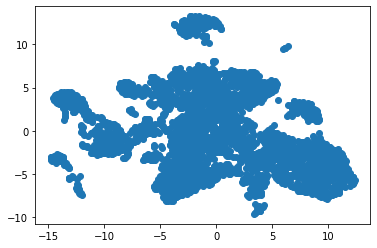

In [5]:
plt.scatter(train_dr[:,0], train_dr[:,1])

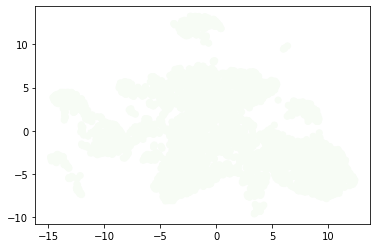

In [6]:
## Plotting GAPDH on the UMAPd cells
gapdh = train_full[:,6051]
plt.scatter(train_dr[:,0], train_dr[:,1], c=gapdh, cmap='Greens')

Text(0.5, 1.0, 'Gaussian on Graph with $\\sigma=5$')

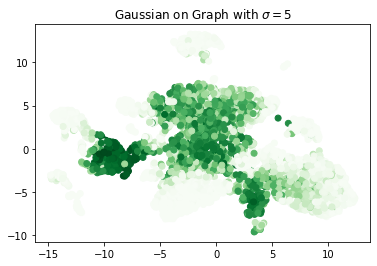

In [7]:
## Plotting a sample Gaussian on the cell graph
gaussian = gaussian_centered_on_vertex(train_full, train_full[100,:], sigma=10)
plt.scatter(train_dr[:,0], train_dr[:,1], c=gaussian, cmap='Greens')
plt.title(r'Gaussian on Graph with $\sigma=5$')

## KNN Graph Construction
We use two methods for clustering, basic KNN Graph construction and [PhenoGraph](https://github.com/dpeerlab/PhenoGraph), a method that constructs a KNN graph and then scales edge weights by the number of shared neighbors between nodes. 

## Computing the Laplacian
We can compute the Laplacian for both weighted and unweighted graphs. 

In [5]:
k = 15 #int(math.sqrt(train_full.shape[0]))

In [9]:
### Get Laplacian
laplacian_all = get_laplacian_from_tome_data(train_full)

### Compute eigen
lambda_all, v_all = get_laplacian_eig_from_laplacian(laplacian_all)

In [6]:
graph = construct_knn_graph(train_full, k)

In [37]:
np.save(DATA_DIR + "adjacency_15NN.npy", graph)
np.savetxt(DATA_DIR + "adjacency_15NN.csv", graph, delimiter=",")

In [13]:
distances = []

for i in range(len(graph)):
    for j in range(len(graph)):
        distances.append(np.linalg.norm(train_full[i,:] - train_full[j,:]))

(array([2.82593855e-02, 7.02624861e-03, 5.41648767e-04, 1.64769055e-04,
        1.71100044e-04, 5.38134054e-05, 1.89422736e-05, 3.58624610e-05,
        4.48914424e-06, 5.06929714e-08, 2.01251096e-05, 2.01814352e-05,
        2.02884537e-05, 4.95664609e-07, 1.97026682e-05, 2.02377607e-05,
        2.81627619e-08, 5.63255238e-09, 1.12651048e-08, 5.63255238e-09,
        5.63255238e-09, 0.00000000e+00, 5.63255238e-09, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.94278666e-08, 2.01814352e-05]),
 array([  0.        ,  27.47432096,  54.94864192,  82.42296288,
        109.89728384, 137.3716048 , 164.84592575, 192.32024671,
        219.79456767, 247.26888863, 274.74320959, 302.21753055,
        329.69185151, 357.16617247, 384.64049343, 412.11481439,
        439.58913534, 467.0634563 , 494.53777726, 522.01209822,
        549.48641918, 576.96074014, 604.4350611 , 631.90938206,
        659.38370302, 686.85802398, 714.33234493, 741.80666589,
      

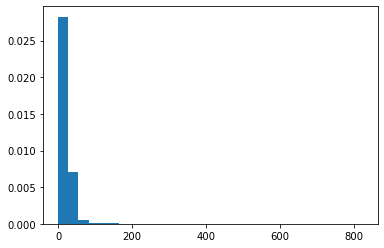

In [14]:
plt.hist(distances, density=True, bins=30, stacked=True)  # density=False would make counts

In [17]:
pd.DataFrame(distances).describe()

,0
count,1.292402e+07
mean,2.203501e+01
std,3.083589e+01
min,0.000000e+00
25%,1.029376e+01
50%,1.733851e+01
75%,2.627674e+01
max,8.242296e+02


In [21]:
graph.sum(axis=1).mean()

83.51265646731572

## Exercises from David for 10/22

In [10]:
## Check that the eigenvectors form a basis by checking orthogonality

v0 = v_all[:,0]
tol = 1e-05
for i in range(1, v_all.shape[0]):
    assert np.dot(v0, v_all[:,i]) < tol

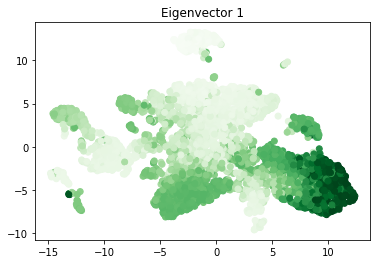

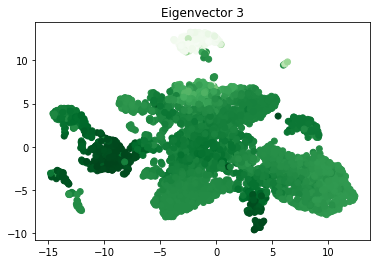

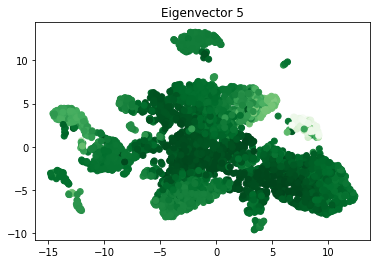

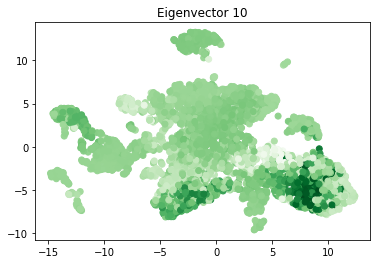

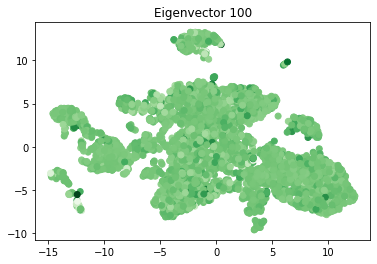

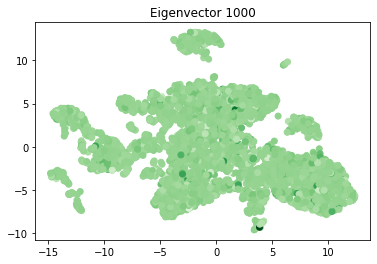

In [11]:
## Plotting the eigenvectors with UMAPd cells
## For k=1,3,5,10,100,1000
ks = [1, 3, 5, 10, 100, 1000]

for k in ks:
    vk = v_all[:,k]
    plt.scatter(train_dr[:,0], train_dr[:,1], c=vk, cmap='Greens')
    plt.title("Eigenvector {}".format(k))
    plt.show()

In [12]:
ks = [1,2,5,10,50,500,1000, 3000, 3595]
for k in ks:
    projection = project_onto_basis(gapdh, v_all, k)
    mse = mean_squared_error(projection, gapdh, squared=False) / gapdh.mean()
    print("RMSE = {} when using the first {} eigenvectors".format(mse, k))

RMSE = 3.4488198107836796e-14 when using the first 1 eigenvectors
RMSE = 3.590636452553335e-14 when using the first 2 eigenvectors
RMSE = 3.5898003647552715e-14 when using the first 5 eigenvectors
RMSE = 3.545762063023734e-14 when using the first 10 eigenvectors
RMSE = 3.540971340437391e-14 when using the first 50 eigenvectors
RMSE = 3.542579872120886e-14 when using the first 500 eigenvectors
RMSE = 3.543583313358246e-14 when using the first 1000 eigenvectors
RMSE = 3.546729483783045e-14 when using the first 3000 eigenvectors
RMSE = 3.5520021344770844e-14 when using the first 3595 eigenvectors


In [13]:
indicator = np.zeros(gapdh.shape[0])
indicator[10] = 1
indicator_projection = project_onto_basis(indicator, v_all, 1000)

[-8.4878  4.7689]


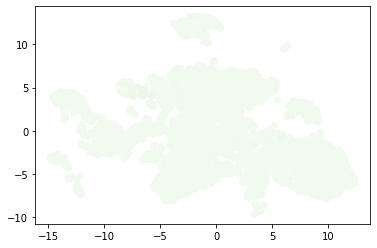

In [14]:
print(train_dr[10])
plt.scatter(train_dr[:,0], train_dr[:,1], c=indicator_projection, cmap='Greens')

## Testing Performance across Methods

### Ending in Graph Space

In [85]:
### Inputs

train_tensor = torch.tensor(train_full).float()
valid_tensor = torch.tensor(valid_full).float()

binary_matrix_filepath = MODELS_DIR + 'binary_matrix.npy'
binary_matrix = np.load(binary_matrix_filepath)
binary_matrix = torch.tensor(binary_matrix).float()

train_binary_tensor = torch.matmul(train_tensor, binary_matrix)
valid_binary_tensor = torch.matmul(valid_tensor, binary_matrix)

In [130]:
### Outputs
gaussian_train = np.load(DATA_DIR + 'precomputed_gaussian.npy')
indicator_train = np.identity(train_full.shape[0])

closest_cell_to_valid = np.load(DATA_DIR + 'closest_cell_to_valid.npy')

gaussian_valid = np.apply_along_axis(lambda x: gaussian_train[x,:], 0, closest_cell_to_valid)

indicator_valid = []
for i in closest_cell_to_valid:
    indicator_valid.append(one_at(len(train_full), i))
indicator_valid = np.array(indicator_valid)

In [104]:
### Models

autoencoder = torch.load('models/autoencoder.pt').eval()
decoder = autoencoder.decoder

binaryToLaplacian = torch.load('models/binaryToLaplacian.pt').eval()
binaryToEncoded = torch.load('models/binaryToEncoded.pt').eval()

tomeToLaplacian = torch.load('models/tomeToLaplacian.pt').eval()
tomeToLaplacianBottlenecked = torch.load('models/tomeToLaplacianBottlenecked.pt').eval()

In [221]:
### Transforms
toGraph = lambda X: np.apply_along_axis(lambda y: laplacian_coefficients_to_probability(y, v_all), 1, X)
# Gene space to graph space
t2G = [tomeToLaplacian, toGraph]

# Gene space to graph space; bottlenecked
t2Gb = [tomeToLaplacianBottlenecked, toGraph]

# Gene to gene to graph
t2t2G = [autoencoder, tomeToLaplacian, toGraph]

# Binary to graph
b2G = [binaryToLaplacian, toGraph]

# Binary to gene to graph
b2t2G = [binaryToEncoded, decoder, tomeToLaplacian, toGraph]

In [222]:
## Losses look very uniform...strange
## Some validation losses are also smaller than training losses

with torch.no_grad():
    ## Gene to Graph
    t2GGaussianTrainloss = transform_and_compute_error(train_tensor, gaussian_train, 
                                                       t2G, cross_entropy_on_matrix)
    t2GIndicatorTrainloss = transform_and_compute_error(train_tensor, indicator_train, 
                                                        t2G, cross_entropy_on_matrix)
    
    t2GGaussianValidloss = transform_and_compute_error(valid_tensor, gaussian_valid, 
                                                       t2G, cross_entropy_on_matrix)
    t2GIndicatorValidloss = transform_and_compute_error(valid_tensor, indicator_valid, 
                                                        t2G, cross_entropy_on_matrix)
    
    ## Gene to Graph (bottlenecked)
    
    t2GbGaussianTrainloss = transform_and_compute_error(train_tensor, gaussian_train, 
                                                        t2Gb, cross_entropy_on_matrix)
    t2GbIndicatorTrainloss = transform_and_compute_error(train_tensor, indicator_train, 
                                                         t2Gb, cross_entropy_on_matrix)
    
    t2GbGaussianValidloss = transform_and_compute_error(valid_tensor, gaussian_valid, 
                                                        t2Gb, cross_entropy_on_matrix)
    t2GbIndicatorValidloss = transform_and_compute_error(valid_tensor, indicator_valid, 
                                                         t2Gb, cross_entropy_on_matrix)
    
    ## Gene to gene (AE) to graph
    
    t2t2GGaussianTrainloss = transform_and_compute_error(train_tensor, gaussian_train, 
                                                         t2t2G, cross_entropy_on_matrix)
    t2t2GIndicatorTrainloss = transform_and_compute_error(train_tensor, indicator_train, 
                                                          t2t2G, cross_entropy_on_matrix)
    
    t2t2GGaussianValidloss = transform_and_compute_error(valid_tensor, gaussian_valid, 
                                                         t2t2G, cross_entropy_on_matrix)
    t2t2GIndicatorValidloss = transform_and_compute_error(valid_tensor, indicator_valid, 
                                                          t2t2G, cross_entropy_on_matrix)
    
    ## Binary to Graph
    
    b2GGaussianTrainloss = transform_and_compute_error(train_binary_tensor, gaussian_train, 
                                                       b2G, cross_entropy_on_matrix)
    b2GIndicatorTrainloss = transform_and_compute_error(train_binary_tensor, 
                                               indicator_train, b2G, cross_entropy_on_matrix)
    
    b2GGaussianValidloss = transform_and_compute_error(valid_binary_tensor, gaussian_valid, 
                                                       b2G, cross_entropy_on_matrix)
    b2GIndicatorValidloss = transform_and_compute_error(valid_binary_tensor, 
                                               indicator_valid, b2G, cross_entropy_on_matrix)
    
    ## Binary to Gene to Graph
    
    b2t2GGaussianTrainloss = transform_and_compute_error(train_binary_tensor, 
                                                gaussian_train, b2t2G, cross_entropy_on_matrix)
    b2t2GIndicatorTrainloss = transform_and_compute_error(train_binary_tensor, 
                                               indicator_train, b2t2G, cross_entropy_on_matrix)
    
    b2t2GGaussianValidloss = transform_and_compute_error(valid_binary_tensor, 
                                                gaussian_valid, b2t2G, cross_entropy_on_matrix)
    b2t2GIndicatorValidloss = transform_and_compute_error(valid_binary_tensor, 
                                               indicator_valid, b2t2G, cross_entropy_on_matrix)

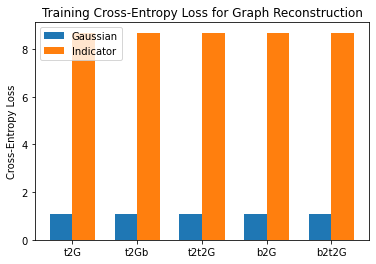

In [226]:
labels = ['t2G', 't2Gb', 't2t2G', 'b2G', 'b2t2G']
gaussian_errors = [t2GGaussianTrainloss, t2GbGaussianTrainloss, t2t2GGaussianTrainloss, b2GGaussianTrainloss,
                  b2t2GGaussianTrainloss]
indicator_errors = [t2GIndicatorTrainloss, t2GbIndicatorTrainloss, t2t2GIndicatorTrainloss, b2GIndicatorTrainloss,
                  b2t2GIndicatorTrainloss]

ind = np.arange(len(labels)) 
width = 0.35       
plt.bar(ind, gaussian_errors, width, label='Gaussian')
plt.bar(ind + width, indicator_errors, width,
    label='Indicator')

plt.ylabel('Cross-Entropy Loss')
plt.title('Training Cross-Entropy Loss for Graph Reconstruction')

plt.xticks(ind + width / 2, labels)
plt.legend(loc='best')
plt.show()

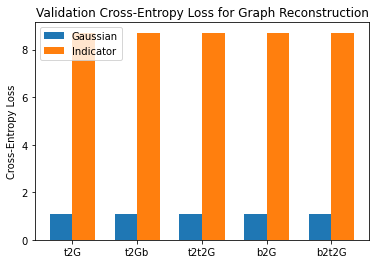

In [227]:
labels = ['t2G', 't2Gb', 't2t2G', 'b2G', 'b2t2G']
gaussian_errors = [t2GGaussianValidloss, t2GbGaussianValidloss, t2t2GGaussianValidloss, b2GGaussianValidloss,
                  b2t2GGaussianTrainloss]
indicator_errors = [t2GIndicatorValidloss, t2GbIndicatorValidloss, t2t2GIndicatorValidloss, b2GIndicatorValidloss,
                  b2t2GIndicatorTrainloss]



ind = np.arange(len(labels)) 
width = 0.35       
plt.bar(ind, gaussian_errors, width, label='Gaussian')
plt.bar(ind + width, indicator_errors, width,
    label='Indicator')

plt.ylabel('Cross-Entropy Loss')
plt.title('Validation Cross-Entropy Loss for Graph Reconstruction')

plt.xticks(ind + width / 2, labels)
plt.legend(loc='best')
plt.show()

### Ending in Gene Space

In [236]:
### Transforms
toGene = lambda X: np.apply_along_axis(lambda y: graph_to_tome_space(train_full, y), 1, X)
toGeneWeighted = lambda X: np.apply_along_axis(lambda y: graph_to_tome_space(train_full, y, weighted=True), 1, X)
error = lambda X, Y: ((X - Y)**2).mean()
# Gene space to graph space to gene space
t2G2t = [tomeToLaplacian, toGraph, toGene]
t2G2tW = [tomeToLaplacian, toGraph, toGeneWeighted]

# Gene space to graph space; bottlenecked, to gene space
t2G2tb = [tomeToLaplacianBottlenecked, toGraph, toGene]
t2G2tWb = [tomeToLaplacianBottlenecked, toGraph, toGeneWeighted]

# Gene to gene to graph to gene
t2tG2t = [autoencoder, tomeToLaplacian, toGraph, toGene]
t2tG2tW = [autoencoder, tomeToLaplacian, toGraph, toGeneWeighted]

# Binary to graph to gene
b2G2t = [binaryToLaplacian, toGraph, toGene]
b2G2tW = [binaryToLaplacian, toGraph, toGeneWeighted]

# Binary to gene to graph to gene
b2t2G2t = [binaryToEncoded, decoder, tomeToLaplacian, toGraph, toGene]
b2t2G2tW = [binaryToEncoded, decoder, tomeToLaplacian, toGraph, toGeneWeighted]

# Binary to gene
deb2t = [binaryToEncoded, decoder]

In [250]:
def transform(X, transforms):
    d = torch.clone(X)
    for transform in transforms:
        d = transform(d)
    return d

def transform_and_compute_error(X, Y, transforms, error):
    d = transform(X, transforms)
    return d, error(Y, d)

In [251]:
with torch.no_grad():
    ## Gene to Graph to Gene
    t2G2tTrain, t2G2tTrainloss = transform_and_compute_error(train_tensor, train_tensor, t2G2t, error)
    t2G2tWTrain, t2G2tWTrainloss = transform_and_compute_error(train_tensor, train_tensor, t2G2tW, error)
    
    t2G2tValid, t2G2tValidloss = transform_and_compute_error(valid_tensor, valid_tensor, t2G2t, error)
    t2G2tWValid, t2G2tWValidloss = transform_and_compute_error(valid_tensor, valid_tensor, t2G2tW, error)
    
    ## Gene to Graph; Bottlenecked, to Gene
    t2G2tbTrain, t2G2tbTrainloss = transform_and_compute_error(train_tensor, train_tensor, t2G2tb, error)
    t2G2tWbTrain, t2G2tWbTrainloss = transform_and_compute_error(train_tensor, train_tensor, t2G2tWb, error)
    
    t2G2tbValid, t2G2tbValidloss = transform_and_compute_error(valid_tensor, valid_tensor, t2G2tb, error)
    t2G2tWbValid, t2G2tWbValidloss = transform_and_compute_error(valid_tensor, valid_tensor, t2G2tWb, error)
    
    ## Gene to Gene to Graph to Gene
    t2tG2tTrain, t2tG2tTrainloss = transform_and_compute_error(train_tensor, train_tensor, t2tG2t, error)
    t2tG2tWTrain, t2tG2tWTrainloss = transform_and_compute_error(train_tensor, train_tensor, t2tG2tW, error)
    
    t2tG2tValid, t2tG2tValidloss = transform_and_compute_error(valid_tensor, valid_tensor, t2tG2t, error)
    t2tG2tWValid, t2tG2tWValidloss = transform_and_compute_error(valid_tensor, valid_tensor, t2tG2tW, error)
    
    ## Binary to Graph to Gene
    b2G2tTrain, b2G2tTrainloss = transform_and_compute_error(train_binary_tensor, train_tensor, b2G2t, error)
    b2G2tWTrain, b2G2tWTrainloss = transform_and_compute_error(train_binary_tensor, train_tensor, b2G2tW, error)
    
    b2G2tValid, b2G2tValidloss = transform_and_compute_error(valid_binary_tensor, valid_tensor, b2G2t, error)
    b2G2tWValid, b2G2tWValidloss = transform_and_compute_error(valid_binary_tensor, valid_tensor, b2G2tW, error)
    
    ## Binary to Gene to Graph to Gene
    b2t2G2tTrain, b2t2G2tTrainloss = transform_and_compute_error(train_binary_tensor, train_tensor, b2t2G2t, error)
    b2t2G2tWTrain, b2t2G2tWTrainloss = transform_and_compute_error(train_binary_tensor, train_tensor, b2t2G2tW, error)
    
    b2t2G2tValid, b2t2G2tValidloss = transform_and_compute_error(valid_binary_tensor, valid_tensor, b2t2G2t, error)
    b2t2G2tWValid, b2t2G2tWValidloss = transform_and_compute_error(valid_binary_tensor, valid_tensor, b2t2G2tW, error)
    
    # Binary to Gene
    b2tTrain, b2tTrainloss = transform_and_compute_error(train_binary_tensor, train_tensor, b2t, error)
    
    b2tValid, b2tValidloss = transform_and_compute_error(valid_binary_tensor, valid_tensor, b2t, error)

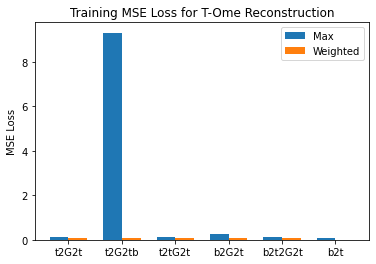

In [241]:
labels = ['t2G2t', 't2G2tb', 't2tG2t', 'b2G2t', 'b2t2G2t', 'b2t']
max_errors = [t2G2tTrainloss, t2G2tbTrainloss, t2tG2tTrainloss, b2G2tTrainloss,
                  b2t2G2tTrainloss, b2tTrainloss]
weighted_errors = [t2G2tWTrainloss, t2G2tWbTrainloss, t2tG2tWTrainloss, b2G2tWTrainloss,
                  b2t2G2tWTrainloss, 0]

ind = np.arange(len(labels)) 
width = 0.35       
plt.bar(ind, max_errors, width, label='Max')
plt.bar(ind + width, weighted_errors, width,
    label='Weighted')

plt.ylabel('MSE Loss')
plt.title('Training MSE Loss for T-Ome Reconstruction')

plt.xticks(ind + width / 2, labels)
plt.legend(loc='best')
plt.show()

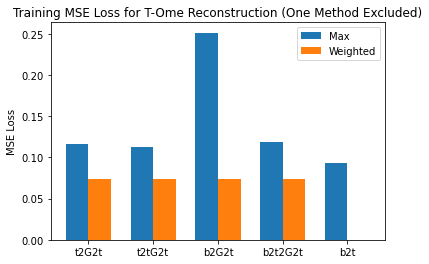

In [243]:
labels = ['t2G2t', 't2tG2t', 'b2G2t', 'b2t2G2t', 'b2t']
max_errors = [t2G2tTrainloss, t2tG2tTrainloss, b2G2tTrainloss,
                  b2t2G2tTrainloss, b2tTrainloss]
weighted_errors = [t2G2tWTrainloss, t2tG2tWTrainloss, b2G2tWTrainloss,
                  b2t2G2tWTrainloss, 0]

ind = np.arange(len(labels)) 
width = 0.35       
plt.bar(ind, max_errors, width, label='Max')
plt.bar(ind + width, weighted_errors, width,
    label='Weighted')

plt.ylabel('MSE Loss')
plt.title('Training MSE Loss for T-Ome Reconstruction (One Method Excluded)')

plt.xticks(ind + width / 2, labels)
plt.legend(loc='best')
plt.show()

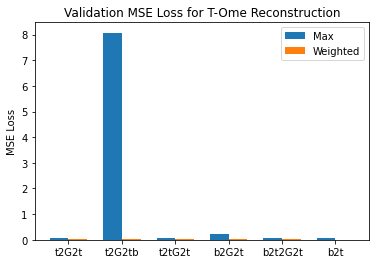

In [252]:
labels = ['t2G2t', 't2G2tb', 't2tG2t', 'b2G2t', 'b2t2G2t', 'b2t']
max_errors = [t2G2tValidloss, t2G2tbValidloss, t2tG2tValidloss, b2G2tValidloss,
                  b2t2G2tValidloss, b2tValidloss]
weighted_errors = [t2G2tWValidloss, t2G2tWbValidloss, t2tG2tWValidloss, b2G2tWValidloss,
                  b2t2G2tWValidloss, 0]

ind = np.arange(len(labels)) 
width = 0.35       
plt.bar(ind, max_errors, width, label='Max')
plt.bar(ind + width, weighted_errors, width,
    label='Weighted')

plt.ylabel('MSE Loss')
plt.title('Validation MSE Loss for T-Ome Reconstruction')

plt.xticks(ind + width / 2, labels)
plt.legend(loc='best')
plt.show()

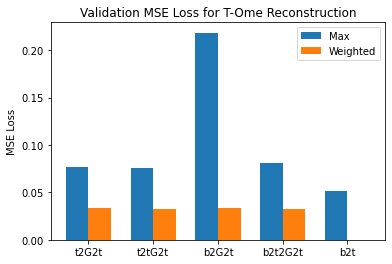

In [254]:
labels = ['t2G2t', 't2tG2t', 'b2G2t', 'b2t2G2t', 'b2t']
max_errors = [t2G2tValidloss, t2tG2tValidloss, b2G2tValidloss,
                  b2t2G2tValidloss, b2tValidloss]
weighted_errors = [t2G2tWValidloss, t2tG2tWValidloss, b2G2tWValidloss,
                  b2t2G2tWValidloss, 0]

ind = np.arange(len(labels)) 
width = 0.35       
plt.bar(ind, max_errors, width, label='Max')
plt.bar(ind + width, weighted_errors, width,
    label='Weighted')

plt.ylabel('MSE Loss')
plt.title('Validation MSE Loss for T-Ome Reconstruction')

plt.xticks(ind + width / 2, labels)
plt.legend(loc='best')
plt.show()

### Quiver Plots of Reconstructions

In [249]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
valid_tsne = tsne.fit_transform(valid_full)

/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 719 samples in 0.002s...
[t-SNE] Computed neighbors for 719 samples in 0.087s...
[t-SNE] Computed conditional probabilities for sample 719 / 719
[t-SNE] Mean sigma: 2.369842
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.293045
[t-SNE] KL divergence after 300 iterations: 0.507154


In [255]:
reconstructions = [t2G2tValid, t2G2tbValid, t2tG2tValid, b2G2tValid, b2t2G2tValid, 
                   b2tValid, t2G2tWValid, t2G2tWbValid, t2tG2tWValid, b2G2tWValid, b2t2G2tWValid]
labels = ['t2G2t', 't2G2tb', 't2tG2t', 'b2G2t', 'b2t2G2t', 
                   'b2t', 't2G2tW', 't2G2tWb', 't2tG2tW', 'b2G2tW', 'b2t2G2tW']
reconstructions = [tsne.fit_transform(x) for x in reconstructions]
vectors = [x - valid_tsne for x in reconstructions]

/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 719 samples in 0.003s...
[t-SNE] Computed neighbors for 719 samples in 0.076s...
[t-SNE] Computed conditional probabilities for sample 719 / 719
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 109.781754
[t-SNE] KL divergence after 300 iterations: 3.055398
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 719 samples in 0.002s...
[t-SNE] Computed neighbors for 719 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 719 / 719
[t-SNE] Mean sigma: 0.000000


/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.631065
[t-SNE] KL divergence after 300 iterations: 0.530675
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 719 samples in 0.002s...


/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 719 samples in 0.123s...
[t-SNE] Computed conditional probabilities for sample 719 / 719
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 0.000000
[t-SNE] KL divergence after 300 iterations: 0.000000
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 719 samples in 0.002s...
[t-SNE] Computed neighbors for 719 samples in 0.074s...
[t-SNE] Computed conditional probabilities for sample 719 / 719
[t-SNE] Mean sigma: 0.000000


/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.127281
[t-SNE] KL divergence after 300 iterations: 1.268409
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 719 samples in 0.002s...


/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 719 samples in 0.091s...
[t-SNE] Computed conditional probabilities for sample 719 / 719
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.723755
[t-SNE] KL divergence after 300 iterations: 1.764435
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 719 samples in 0.002s...


/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 719 samples in 0.346s...
[t-SNE] Computed conditional probabilities for sample 719 / 719
[t-SNE] Mean sigma: 0.090954
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.623478
[t-SNE] KL divergence after 300 iterations: 0.247297
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 719 samples in 0.002s...
[t-SNE] Computed neighbors for 719 samples in 0.091s...
[t-SNE] Computed conditional probabilities for sample 719 / 719
[t-SNE] Mean sigma: 0.000188


/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.147659
[t-SNE] KL divergence after 300 iterations: 0.203144
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 719 samples in 0.002s...
[t-SNE] Computed neighbors for 719 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 719 / 719
[t-SNE] Mean sigma: 0.001534


/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.574635
[t-SNE] KL divergence after 300 iterations: 0.230105
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 719 samples in 0.002s...
[t-SNE] Computed neighbors for 719 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 719 / 719
[t-SNE] Mean sigma: 0.000003


/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.969154
[t-SNE] KL divergence after 300 iterations: 0.203935
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 719 samples in 0.002s...
[t-SNE] Computed neighbors for 719 samples in 0.077s...
[t-SNE] Computed conditional probabilities for sample 719 / 719
[t-SNE] Mean sigma: 0.002919


/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.247921
[t-SNE] KL divergence after 300 iterations: 0.362617
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 719 samples in 0.002s...
[t-SNE] Computed neighbors for 719 samples in 0.076s...
[t-SNE] Computed conditional probabilities for sample 719 / 719
[t-SNE] Mean sigma: 0.000002


/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kushagrasharma/miniforge3/envs/rna_sensor/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.191238
[t-SNE] KL divergence after 300 iterations: 0.205847


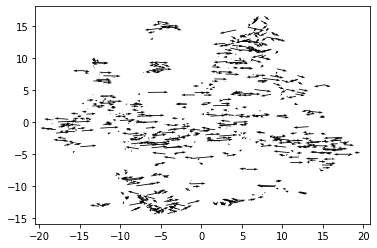

In [257]:
fig, ax = plt.subplots()

ax.quiver(valid_tsne[:,0],valid_tsne[:,1],vectors[0][:,0],vectors[1][:,1])

### Comparing Binary Matrix Performance

<AxesSubplot:xlabel='N_binary', ylabel='N_combinations'>

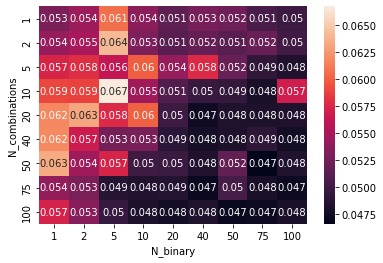

In [218]:
binaryPerformance = pd.read_csv(DATA_DIR + 'binaryMatrixParamSearchResults.csv')
binaryPerformance.index = pd.MultiIndex.from_arrays(binaryPerformance[['N_binary', 'N_combinations']].values.T, names=['N_binary', 'N_combinations'])
binaryPerformance = binaryPerformance.drop(['N_binary', 'N_combinations'], axis = 1)
sns.heatmap(binaryPerformance.reset_index().pivot(columns='N_binary',index='N_combinations',values='valid_loss'), annot=True)

### Comparing Laplacian Reconstruction With a Neural Network

In [192]:
n_coeffs = 100

laplacianToIndicator = torch.load(MODELS_DIR + 'laplacianToIndicator.pt').eval()
valid_laplacian_projection = np.apply_along_axis(lambda x: get_laplacian_coefficients(x, v_l), 
                                                     1, indicator_valid)[:, :n_coeffs]

with torch.no_grad():
    nn_reconstruction = laplacianToIndicator(valid_laplacian_projection)
    
laplacian_reconstruction = toGraph(valid_laplacian_projection)

nn_error = cross_entropy_on_matrix(nn_reconstruction, indicator_valid)
laplacian_error = cross_entropy_on_matrix(laplacian_reconstruction, indicator_valid)

FileNotFoundError: [Errno 2] No such file or directory: 'models/laplacianToIndicator.pt'

In [29]:
neigh = NearestNeighbors(n_neighbors=11, n_jobs=-1)
neigh.fit(train_full)

NearestNeighbors(n_jobs=-1, n_neighbors=11)

In [30]:
%%time
ten_neighbors = neigh.kneighbors(train_full, return_distance=True)
print()


CPU times: user 1min 22s, sys: 797 ms, total: 1min 23s
Wall time: 12.1 s


In [33]:
ten_neighbors[0][:,-1][0]

2.891576725151393

In [7]:
graph

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
for i in range(len(graph)):
    for j in range(len(graph)):
        if graph[i,j]:
            print(i,j)

0 30
0 153
0 198
0 319
0 479
0 575
0 700
0 716
0 733
0 792
0 1062
0 1415
0 1454
0 1481
0 1569
0 1773
0 1953
0 1993
0 2030
0 2036
0 2156
0 2311
0 2334
0 2469
0 2815
0 2866
0 2973
0 3347
0 3489
0 3529
0 3533
0 3540
1 268
1 653
1 882
1 928
1 931
1 1306
1 1546
1 1582
1 2043
1 2076
1 2629
1 2655
1 2921
1 3034
1 3060
1 3355
1 3372
1 3472
2 25
2 81
2 165
2 188
2 232
2 245
2 587
2 1039
2 1050
2 1483
2 1506
2 1787
2 2069
2 2096
2 2148
2 2162
2 2269
2 2339
2 2686
2 3465
3 456
3 564
3 750
3 786
3 1160
3 1221
3 1462
3 1665
3 1824
3 1857
3 1916
3 1921
3 2395
3 2396
3 2561
3 2806
3 3267
3 3356
4 32
4 96
4 395
4 648
4 655
4 753
4 948
4 972
4 1108
4 1484
4 1550
4 1694
4 1704
4 1737
4 2441
4 2553
4 2609
4 2724
4 2735
4 3050
4 3337
4 3396
4 3502
4 3514
4 3550
5 9
5 310
5 327
5 437
5 468
5 544
5 672
5 856
5 1018
5 1131
5 1211
5 1294
5 1347
5 1653
5 1667
5 1743
5 1755
5 1797
5 1890
5 2107
5 2127
5 2473
5 2758
5 2903
5 2931
5 3304
5 3499
6 207
6 445
6 461
6 630
6 812
6 1015
6 1096
6 1459
6 1548
6 1736
6 17

57 1852
57 2518
57 2604
57 2607
57 2896
57 2962
57 3089
57 3331
57 3472
58 147
58 535
58 559
58 740
58 1045
58 1244
58 1962
58 2053
58 2096
58 2111
58 2138
58 2168
58 2242
58 2308
58 2392
58 2415
58 2491
58 2610
58 2862
58 2937
58 2986
58 2999
58 3039
58 3042
58 3052
58 3340
58 3494
59 16
59 37
59 118
59 196
59 216
59 229
59 730
59 799
59 828
59 995
59 999
59 1066
59 1206
59 1566
59 1581
59 1632
59 1644
59 1879
59 2001
59 2105
59 2205
59 2258
59 2431
59 2516
59 2707
59 2878
59 3379
59 3414
60 684
60 1004
60 1034
60 1081
60 1118
60 1284
60 1582
60 1720
60 1799
60 2182
60 2218
60 2240
60 2289
60 2499
60 2714
60 2841
60 2917
60 3116
60 3299
60 3404
61 128
61 256
61 462
61 527
61 629
61 723
61 724
61 754
61 785
61 1043
61 1065
61 1141
61 1215
61 1262
61 1538
61 1785
61 2011
61 2483
61 2923
61 2928
61 3072
61 3250
62 461
62 465
62 630
62 1096
62 1459
62 1511
62 1623
62 1736
62 1749
62 1822
62 2129
62 2411
62 2559
62 2671
62 2732
62 2739
62 2940
62 3352
62 3583
63 322
63 409
63 428
63 1022
6

166 592
166 613
166 1059
166 1135
166 1253
166 1312
166 1380
166 1425
166 1459
166 1573
166 1707
166 1910
166 2022
166 2092
166 2636
167 224
167 538
167 562
167 801
167 1250
167 1526
167 1802
167 1840
167 1844
167 1875
167 1977
167 2662
167 2875
167 3291
167 3349
167 3387
167 3405
167 3503
167 3572
168 129
168 201
168 307
168 412
168 424
168 642
168 850
168 968
168 1200
168 1514
168 1674
168 1824
168 2142
168 2183
168 2233
168 2264
168 2515
168 2631
168 2691
168 2752
168 2786
168 2913
168 2919
168 3033
168 3247
168 3393
168 3507
169 248
169 353
169 401
169 568
169 807
169 1017
169 1242
169 1874
169 1908
169 2115
169 2474
169 2755
169 2823
169 2982
169 3036
169 3086
169 3221
169 3327
170 155
170 269
170 348
170 560
170 809
170 1803
170 1989
170 2098
170 2247
170 2306
170 2314
170 2439
170 2674
170 2859
170 2949
170 2993
170 3179
170 3358
170 3406
170 3441
171 111
171 155
171 189
171 193
171 340
171 348
171 489
171 560
171 1010
171 1033
171 1218
171 1268
171 1353
171 1435
171 1439
171 14

222 1450
222 1874
222 1926
222 2221
222 2384
222 2389
222 2487
222 2699
222 2755
222 2881
222 3158
222 3271
222 3343
223 41
223 239
223 485
223 497
223 518
223 1303
223 1355
223 1419
223 1424
223 1819
223 2141
223 2257
223 2382
223 2414
223 2711
223 2941
223 3092
223 3155
223 3293
223 3364
223 3493
223 3527
224 167
224 279
224 289
224 907
224 1066
224 1250
224 1300
224 1526
224 1566
224 1844
224 1862
224 1879
224 1913
224 1952
224 1977
224 2008
224 2048
224 2447
224 2516
224 2570
224 2662
224 3213
224 3291
224 3349
224 3405
224 3414
224 3503
224 3524
224 3572
225 297
225 441
225 470
225 639
225 1002
225 1157
225 1194
225 1758
225 2196
225 2265
225 2272
225 2634
225 2785
225 2920
225 2953
226 222
226 308
226 353
226 401
226 568
226 654
226 845
226 1027
226 1242
226 1261
226 1401
226 1831
226 1874
226 1905
226 2221
226 2389
226 2487
226 2590
226 2755
226 2823
226 2881
226 3086
226 3221
226 3271
226 3491
227 69
227 117
227 375
227 565
227 864
227 870
227 1171
227 1490
227 1564
227 1642
22

280 3025
280 3029
280 3034
280 3077
280 3206
280 3339
280 3408
280 3440
281 67
281 345
281 435
281 569
281 674
281 680
281 868
281 955
281 1340
281 1432
281 1457
281 1701
281 1730
281 1946
281 2038
281 2116
281 2118
281 2144
281 2173
281 2267
281 2530
281 3071
281 3227
281 3263
281 3269
281 3308
281 3584
282 181
282 238
282 557
282 758
282 924
282 1082
282 1175
282 1358
282 1794
282 2125
282 2430
282 2778
282 2968
282 3196
282 3508
283 242
283 472
283 651
283 762
283 845
283 878
283 1774
283 1815
283 1905
283 1975
283 2069
283 2132
283 2506
283 2542
283 2645
283 2672
283 2897
283 3125
283 3166
283 3373
283 3464
283 3484
284 34
284 139
284 621
284 634
284 815
284 996
284 1036
284 1214
284 1285
284 1584
284 1603
284 1646
284 1670
284 2103
284 2109
284 2465
284 2819
284 2882
284 3186
284 3411
285 64
285 106
285 325
285 372
285 460
285 510
285 574
285 1083
285 1187
285 1499
285 2055
285 2317
285 2335
285 2412
285 2591
285 2734
285 2797
285 3002
285 3179
285 3377
285 3518
286 221
286 275
28

342 672
342 1092
342 1164
342 1344
342 1474
342 1856
342 2236
342 2249
342 2285
342 2328
342 2416
342 2780
342 2782
342 3389
342 3578
343 601
343 729
343 1055
343 1329
343 1551
343 1633
343 1852
343 1967
343 2106
343 2185
343 2745
343 2966
343 3037
343 3049
343 3203
343 3512
344 420
344 1197
344 1527
344 1545
344 1671
344 1782
344 1947
344 2214
344 2641
344 2771
344 2802
344 2861
344 3204
344 3453
344 3521
345 281
345 435
345 1340
345 1701
345 1730
345 1946
345 2118
345 2173
345 2267
345 2530
345 3071
345 3263
345 3269
345 3485
345 3584
346 298
346 454
346 512
346 598
346 1102
346 1368
346 1468
346 1620
346 1633
346 1873
346 1900
346 2185
346 2330
346 2374
346 2930
346 2967
346 3190
347 91
347 137
347 625
347 799
347 849
347 903
347 1158
347 1236
347 1321
347 1398
347 1427
347 1644
347 1865
347 2004
347 2105
347 2164
347 2839
347 2946
347 3123
347 3374
347 3423
347 3515
347 3594
348 153
348 155
348 170
348 171
348 189
348 340
348 489
348 560
348 890
348 1305
348 1353
348 1435
348 1803


405 1935
405 1936
405 1945
405 1971
405 2216
405 3319
405 3323
405 3336
406 23
406 79
406 418
406 739
406 911
406 1237
406 1301
406 1545
406 1621
406 1706
406 1740
406 1899
406 2171
406 2420
406 2534
406 2753
406 2844
406 3264
406 3290
406 3378
407 154
407 231
407 606
407 834
407 992
407 1095
407 1440
407 1466
407 1702
407 1760
407 1898
407 2270
407 2397
407 2536
407 2761
407 2906
408 446
408 494
408 942
408 969
408 1825
408 1852
408 1899
408 2025
408 2077
408 2468
408 2486
408 2518
408 2544
408 2574
408 2583
408 2736
408 2921
408 3025
408 3098
408 3168
408 3193
408 3206
408 3339
409 63
409 247
409 428
409 883
409 1022
409 1213
409 1229
409 1396
409 1411
409 1703
409 1718
409 1919
409 2189
409 2350
409 2846
409 2946
409 3004
409 3041
409 3194
410 542
410 744
410 822
410 1009
410 1294
410 1530
410 1795
410 1872
410 2032
410 2088
410 2181
410 2377
410 2726
410 2729
410 2769
410 3015
410 3216
410 3287
410 3318
410 3470
410 3516
411 126
411 274
411 293
411 373
411 405
411 427
411 638
411 8

469 2264
469 3056
469 3507
470 225
470 287
470 350
470 441
470 540
470 876
470 1002
470 1089
470 1106
470 1716
470 1758
470 1906
470 2071
470 2196
470 2265
470 2272
470 2634
470 2785
470 2920
471 15
471 350
471 423
471 496
471 688
471 779
471 1622
471 1798
471 2101
471 2113
471 2243
471 2347
471 2444
471 3132
471 3218
471 3300
471 3317
471 3435
471 3519
471 3555
472 188
472 242
472 283
472 651
472 845
472 851
472 878
472 1027
472 1555
472 1774
472 1831
472 1905
472 1975
472 2132
472 2221
472 2590
472 2610
472 2823
472 2893
472 3288
472 3373
472 3464
472 3586
473 111
473 141
473 262
473 325
473 377
473 956
473 1033
473 1187
473 1268
473 1378
473 1677
473 1915
473 2220
473 2262
473 2454
473 2639
473 3538
474 269
474 365
474 389
474 490
474 507
474 607
474 710
474 899
474 957
474 976
474 1012
474 1152
474 1180
474 1188
474 1204
474 1315
474 1449
474 1491
474 1792
474 1950
474 1989
474 2024
474 2075
474 2247
474 2429
474 2439
474 2443
474 2616
474 2630
474 2674
474 2998
474 3090
474 3154
4

534 666
534 753
534 888
534 948
534 989
534 1005
534 1678
534 2413
534 2492
534 2517
534 2609
534 2645
534 2988
535 58
535 147
535 245
535 671
535 1506
535 1787
535 1962
535 2069
535 2096
535 2242
535 2686
535 2742
535 3042
535 3254
535 3340
535 3494
536 248
536 258
536 399
536 807
536 908
536 970
536 1450
536 1507
536 1786
536 1908
536 1926
536 2099
536 2180
536 2474
536 2554
536 2699
536 2796
536 3036
536 3086
536 3271
536 3582
537 214
537 255
537 273
537 628
537 756
537 761
537 789
537 841
537 985
537 1325
537 1510
537 1578
537 1648
537 2251
537 2253
537 2375
537 2676
537 2912
537 3026
537 3102
537 3109
537 3234
537 3289
537 3537
538 76
538 167
538 821
538 919
538 1220
538 1597
538 1855
538 1875
538 2437
538 2747
538 2875
538 2889
538 3014
538 3103
538 3162
539 36
539 174
539 380
539 506
539 519
539 528
539 585
539 917
539 949
539 953
539 966
539 982
539 1685
539 1710
539 1807
539 2049
539 2239
539 2424
539 2450
539 2579
539 2956
539 2959
539 3244
539 3275
539 3321
539 3475
540 287


585 1147
585 1697
585 2049
585 2202
585 2239
585 2406
585 2424
585 3161
585 3244
585 3488
586 200
586 843
586 1552
586 1659
586 2102
586 2150
586 2183
586 2367
586 2476
586 2631
586 2713
586 2857
586 2936
586 2981
586 3009
587 2
587 188
587 245
587 666
587 889
587 909
587 1008
587 1050
587 1126
587 1264
587 1787
587 2069
587 2351
587 2645
587 2686
587 2886
587 2893
587 2964
587 3494
587 3570
588 10
588 39
588 316
588 526
588 872
588 952
588 1498
588 1520
588 2159
588 2461
588 3008
588 3045
588 3273
588 3398
588 3551
589 20
589 79
589 236
589 357
589 383
589 689
589 810
589 1098
589 1231
589 1616
589 1621
589 1669
589 1733
589 1751
589 1838
589 1851
589 1932
589 2029
589 2086
589 2123
589 2145
589 2219
589 2227
589 2244
589 2302
589 2464
589 2484
589 3245
590 564
590 599
590 619
590 1132
590 1292
590 1465
590 1560
590 1602
590 2303
590 2348
590 2403
590 2741
590 2770
590 2791
590 2840
590 2933
590 3267
590 3301
590 3346
590 3356
591 166
591 207
591 592
591 613
591 812
591 1059
591 1096


644 2300
644 2346
644 2638
644 2812
644 2834
644 3208
644 3320
645 144
645 215
645 263
645 303
645 701
645 826
645 1015
645 1434
645 1475
645 1748
645 2066
645 2228
645 3183
645 3278
645 3310
645 3427
645 3456
646 149
646 218
646 1140
646 1165
646 1304
646 1528
646 1553
646 1568
646 1877
646 2052
646 2361
646 2385
646 2488
646 2532
646 2697
646 2721
646 3229
646 3285
646 3383
646 3438
646 3501
646 3577
647 34
647 621
647 634
647 1036
647 1285
647 1335
647 1603
647 1634
647 1670
647 2237
647 2819
647 2877
647 2882
647 2960
647 3081
647 3225
647 3231
647 3332
647 3350
647 3380
647 3411
647 3498
647 3560
648 4
648 395
648 626
648 860
648 948
648 1093
648 1484
648 1694
648 1737
648 2553
648 2609
648 2724
648 2961
648 3224
648 3502
649 9
649 161
649 468
649 1013
649 1127
649 1202
649 1266
649 1296
649 1430
649 1743
649 1755
649 1795
649 1797
649 1963
649 2107
649 2538
649 2931
650 55
650 123
650 194
650 251
650 744
650 1020
650 1217
650 1387
650 1530
650 2124
650 2154
650 2972
650 3091
650 

705 2171
705 2420
705 2481
705 3060
705 3084
705 3449
706 485
706 633
706 959
706 1223
706 1303
706 1348
706 2279
706 2332
706 2381
706 2414
706 2711
706 2818
706 2955
706 3172
706 3313
706 3420
707 354
707 442
707 571
707 698
707 946
707 1034
707 1284
707 1298
707 1346
707 1454
707 1481
707 1501
707 1542
707 1569
707 1991
707 1997
707 2156
707 2186
707 2218
707 2240
707 2355
707 2582
707 2682
707 2787
707 2805
707 2866
707 2988
707 2994
707 3116
707 3170
708 181
708 257
708 267
708 501
708 557
708 798
708 801
708 821
708 830
708 971
708 1175
708 1376
708 1444
708 1708
708 1729
708 1859
708 1933
708 2405
708 2580
708 2706
708 2747
708 2837
708 2996
708 3080
708 3120
708 3124
708 3185
709 620
709 637
709 712
709 829
709 1019
709 1537
709 1607
709 1934
709 2100
709 2136
709 2343
709 2448
709 2678
709 2896
709 2948
709 2962
709 3089
709 3212
709 3355
709 3359
710 269
710 365
710 474
710 490
710 507
710 510
710 941
710 965
710 974
710 976
710 1033
710 1180
710 1315
710 1449
710 1491
710 16

763 636
763 723
763 785
763 793
763 1141
763 1215
763 1262
763 1375
763 1753
763 2039
763 2280
763 2299
763 2928
763 3139
763 3146
764 33
764 199
764 359
764 567
764 605
764 920
764 983
764 1508
764 1658
764 2000
764 2047
764 2330
764 2353
764 2585
764 2849
764 3137
764 3385
764 3593
765 35
765 124
765 183
765 203
765 212
765 235
765 551
765 899
765 913
765 1152
765 1188
765 1739
765 1813
765 1999
765 2026
765 2121
765 2141
765 2212
765 2225
765 2357
765 2364
765 2407
765 2429
765 2531
765 2679
765 3092
765 3155
765 3293
765 3364
765 3402
765 3481
765 3563
766 85
766 141
766 262
766 300
766 481
766 681
766 790
766 960
766 984
766 1026
766 1148
766 1247
766 1480
766 1509
766 2128
766 2178
766 2262
766 2449
766 2639
766 2658
766 2892
766 3281
766 3400
766 3432
767 151
767 205
767 370
767 602
767 673
767 1014
767 1055
767 1098
767 1133
767 1252
767 1554
767 1869
767 1967
767 2691
767 2702
767 3098
767 3279
767 3453
768 26
768 255
768 422
768 515
768 579
768 622
768 1103
768 1191
768 1442


822 1661
822 1755
822 1795
822 1872
822 2088
822 2377
822 2729
822 2908
822 2926
822 2931
822 3216
822 3522
822 3573
823 296
823 359
823 702
823 742
823 816
823 920
823 983
823 999
823 1411
823 1445
823 1562
823 1627
823 1744
823 2002
823 2020
823 2080
823 2200
823 2354
823 2422
823 2715
823 2902
823 3041
823 3194
823 3344
823 3526
824 156
824 268
824 417
824 525
824 777
824 928
824 931
824 1118
824 1384
824 1513
824 1720
824 1995
824 2043
824 2073
824 2182
824 2301
824 2388
824 2655
824 2754
824 2880
824 2917
824 3299
824 3331
825 31
825 35
825 260
825 633
825 959
825 993
825 1348
825 1355
825 1412
825 1615
825 1842
825 1964
825 2141
825 2225
825 2279
825 2309
825 2332
825 2391
825 2596
825 2670
825 2871
825 3117
825 3246
825 3255
825 3293
825 3364
825 3527
826 144
826 215
826 263
826 303
826 645
826 701
826 1015
826 1434
826 1475
826 1748
826 2066
826 2228
826 2622
826 3183
826 3278
826 3310
826 3427
826 3456
827 315
827 452
827 469
827 669
827 892
827 950
827 1047
827 1084
827 1125


885 2193
885 2376
885 2401
885 2525
885 2611
885 3012
885 3066
885 3104
885 3247
885 3553
886 13
886 197
886 329
886 426
886 759
886 955
886 1168
886 1259
886 1322
886 1721
886 1939
886 2035
886 2158
886 2173
886 2312
886 2824
886 3048
886 3242
886 3269
886 3338
886 3520
886 3557
887 490
887 507
887 957
887 974
887 1048
887 1362
887 1449
887 1491
887 1619
887 1792
887 1950
887 1984
887 2195
887 2212
887 2386
887 2438
887 2573
887 2630
887 2918
887 3409
887 3459
887 3563
887 3568
888 32
888 162
888 241
888 264
888 337
888 534
888 666
888 753
888 948
888 989
888 1005
888 1049
888 1678
888 2126
888 2297
888 2413
888 2609
888 2725
888 2988
888 3375
889 587
889 666
889 909
889 1008
889 1050
889 1126
889 1264
889 1350
889 1787
889 2645
889 2759
889 2893
889 2964
889 3341
889 3494
889 3570
890 189
890 348
890 560
890 632
890 838
890 1010
890 1012
890 1305
890 1435
890 2247
890 2314
890 2478
890 2949
890 3487
890 3505
891 17
891 423
891 496
891 703
891 787
891 790
891 1148
891 1228
891 1480
89

938 2070
938 2302
938 2452
938 2534
938 2569
938 2845
938 2938
938 2977
938 3118
938 3430
938 3510
939 237
939 504
939 803
939 840
939 1165
939 1472
939 1645
939 1686
939 1850
939 2103
939 2324
939 2325
939 2418
939 2488
939 2657
939 2783
939 3207
939 3229
939 3376
940 108
940 143
940 390
940 392
940 402
940 1287
940 1318
940 1323
940 1820
940 2472
940 2509
940 2543
940 2848
940 2879
940 3085
940 3460
940 3567
941 490
941 510
941 696
941 710
941 965
941 1146
941 1180
941 1270
941 1281
941 1315
941 1362
941 1414
941 1416
941 1488
941 1650
941 1654
941 1809
941 1915
941 1984
941 2135
941 2195
941 2217
941 2317
941 3165
941 3171
941 3377
942 408
942 418
942 494
942 832
942 911
942 1098
942 1671
942 1782
942 1899
942 2077
942 2484
942 2510
942 2544
942 2569
942 2736
942 3098
942 3206
942 3279
943 94
943 475
943 676
943 705
943 1301
943 1405
943 1649
943 1733
943 1909
943 2086
943 2171
943 2301
943 2481
943 2564
943 2605
943 3060
944 44
944 244
944 964
944 1051
944 1234
944 1328
944 1637
94

999 2902
999 3284
999 3512
1000 130
1000 545
1000 615
1000 660
1000 743
1000 1020
1000 1314
1000 1485
1000 1577
1000 1883
1000 2015
1000 2318
1000 2390
1000 2637
1000 2651
1000 3016
1000 3087
1001 127
1001 453
1001 838
1001 994
1001 1060
1001 1188
1001 1363
1001 1461
1001 1471
1001 2121
1001 2256
1001 2616
1001 3046
1001 3164
1001 3399
1001 3481
1002 225
1002 297
1002 350
1002 396
1002 441
1002 470
1002 540
1002 639
1002 876
1002 1089
1002 1106
1002 1157
1002 1194
1002 1716
1002 1758
1002 1896
1002 2196
1002 2263
1002 2265
1002 2546
1002 2634
1002 2920
1002 2953
1002 3317
1003 24
1003 78
1003 1162
1003 1265
1003 1300
1003 1696
1003 1726
1003 1977
1003 2025
1003 2031
1003 2167
1003 2547
1003 2626
1003 2772
1003 2802
1003 3291
1003 3292
1003 3379
1003 3572
1003 3581
1004 60
1004 98
1004 354
1004 571
1004 632
1004 752
1004 873
1004 994
1004 1034
1004 1060
1004 1081
1004 1363
1004 1461
1004 1471
1004 1799
1004 1997
1004 2186
1004 2218
1004 2240
1004 2801
1004 3164
1004 3187
1004 3404
1004 

1068 1436
1068 1559
1068 1621
1068 1630
1068 1706
1068 1733
1068 2050
1068 2086
1068 2302
1068 2420
1068 2481
1068 2534
1068 2809
1068 2899
1068 2938
1069 92
1069 308
1069 332
1069 335
1069 581
1069 846
1069 1255
1069 1391
1069 1404
1069 1638
1069 1854
1069 2064
1069 2487
1069 2935
1069 3030
1069 3236
1069 3483
1069 3491
1070 19
1070 199
1070 296
1070 512
1070 602
1070 605
1070 833
1070 920
1070 923
1070 1055
1070 1075
1070 1508
1070 1658
1070 2200
1070 2295
1070 2585
1070 3284
1070 3385
1070 3512
1071 185
1071 322
1071 599
1071 631
1071 727
1071 905
1071 1041
1071 1229
1071 1421
1071 1467
1071 1812
1071 1870
1071 1987
1071 2305
1071 2313
1071 2352
1071 2712
1071 2751
1071 2976
1071 3043
1071 3419
1071 3463
1071 3566
1071 3576
1072 329
1072 393
1072 514
1072 547
1072 759
1072 788
1072 868
1072 1168
1072 1457
1072 1721
1072 2035
1072 2143
1072 2173
1072 2779
1072 3075
1072 3269
1072 3485
1072 3584
1073 23
1073 140
1073 236
1073 452
1073 610
1073 810
1073 991
1073 1086
1073 1201
1073 150

1139 1696
1139 1818
1139 1879
1139 2063
1139 2104
1139 2191
1139 2689
1139 3184
1139 3189
1139 3480
1140 149
1140 218
1140 371
1140 425
1140 524
1140 646
1140 751
1140 1080
1140 1219
1140 1528
1140 1553
1140 1568
1140 1586
1140 1943
1140 2052
1140 2361
1140 2370
1140 2532
1140 2696
1140 2697
1140 2721
1140 3150
1140 3229
1140 3285
1140 3438
1140 3501
1140 3577
1141 61
1141 128
1141 256
1141 422
1141 723
1141 754
1141 763
1141 793
1141 1065
1141 1215
1141 1262
1141 1290
1141 1375
1141 1538
1141 2299
1141 2673
1141 2928
1141 3139
1142 103
1142 105
1142 321
1142 509
1142 593
1142 881
1142 919
1142 1025
1142 1045
1142 1150
1142 1277
1142 1394
1142 1655
1142 1955
1142 2111
1142 2261
1142 2738
1142 3348
1142 3588
1143 574
1143 603
1143 760
1143 1146
1143 1413
1143 1416
1143 1543
1143 1675
1143 1805
1143 1809
1143 1951
1143 2110
1143 2153
1143 2479
1143 2498
1143 3165
1143 3171
1143 3305
1143 3517
1144 518
1144 748
1144 857
1144 1355
1144 1412
1144 1823
1144 1923
1144 1949
1144 2056
1144 2093

1197 2660
1197 2861
1197 2916
1197 3204
1198 176
1198 370
1198 486
1198 610
1198 755
1198 827
1198 1086
1198 1781
1198 2133
1198 2183
1198 2691
1198 2713
1198 2919
1198 2933
1198 3033
1198 3093
1198 3393
1198 3442
1199 81
1199 165
1199 220
1199 248
1199 258
1199 851
1199 1105
1199 1117
1199 1453
1199 1574
1199 1608
1199 1908
1199 1926
1199 2007
1199 2009
1199 2310
1199 2384
1199 2459
1199 2474
1199 2685
1199 2807
1199 2808
1199 2982
1199 3343
1200 129
1200 168
1200 412
1200 424
1200 457
1200 483
1200 642
1200 853
1200 1090
1200 1197
1200 1565
1200 1596
1200 1598
1200 1674
1200 2510
1200 2515
1200 2691
1200 2752
1200 2786
1200 2913
1200 2919
1200 3279
1201 122
1201 404
1201 452
1201 715
1201 813
1201 895
1201 1028
1201 1073
1201 1170
1201 1227
1201 1263
1201 1463
1201 1567
1201 1808
1201 1960
1201 2084
1201 2133
1201 2344
1201 2368
1201 2598
1201 2975
1201 3047
1201 3061
1201 3368
1201 3430
1202 161
1202 649
1202 1013
1202 1054
1202 1266
1202 1430
1202 1702
1202 1795
1202 1898
1202 1963

1265 1696
1265 1726
1265 2025
1265 2031
1265 2157
1265 2167
1265 2214
1265 2626
1265 2660
1265 2772
1265 2802
1265 3029
1265 3122
1265 3292
1265 3440
1266 161
1266 327
1266 542
1266 544
1266 649
1266 1202
1266 1294
1266 1336
1266 1430
1266 1743
1266 1795
1266 1963
1266 2032
1266 2058
1266 2107
1266 2377
1266 2684
1266 2908
1266 2931
1266 2965
1266 3412
1267 483
1267 690
1267 844
1267 894
1267 980
1267 1155
1267 1311
1267 1804
1267 2151
1267 2193
1267 2213
1267 2401
1267 2525
1267 2925
1267 3012
1267 3351
1267 3553
1267 3562
1268 111
1268 141
1268 171
1268 262
1268 325
1268 358
1268 377
1268 473
1268 956
1268 1187
1268 1803
1268 1915
1268 1989
1268 2220
1268 2639
1268 3538
1269 57
1269 156
1269 211
1269 601
1269 777
1269 962
1269 969
1269 1040
1269 1122
1269 1329
1269 1551
1269 1852
1269 2518
1269 2607
1269 2774
1269 3084
1270 389
1270 490
1270 607
1270 941
1270 976
1270 1146
1270 1281
1270 1416
1270 1619
1270 1631
1270 1792
1270 1984
1270 2075
1270 2135
1270 2195
1270 2630
1270 2998
12

1327 2878
1327 3211
1327 3388
1328 44
1328 244
1328 499
1328 583
1328 818
1328 944
1328 1051
1328 1234
1328 1689
1328 2160
1328 2934
1328 3177
1328 3181
1328 3258
1328 3330
1328 3443
1329 211
1329 343
1329 512
1329 598
1329 601
1329 781
1329 969
1329 1040
1329 1133
1329 1252
1329 1269
1329 1531
1329 1551
1329 1633
1329 1852
1329 1909
1329 2106
1329 2157
1329 2185
1329 2278
1329 2745
1329 2966
1329 3037
1329 3057
1329 3084
1329 3134
1329 3203
1329 3298
1329 3453
1330 66
1330 232
1330 378
1330 775
1330 1052
1330 1243
1330 1483
1330 1588
1330 1938
1330 2148
1330 2162
1330 2269
1330 2320
1330 2571
1330 2687
1330 2773
1330 2776
1330 2842
1330 2900
1330 3017
1331 715
1331 802
1331 813
1331 1028
1331 1227
1331 1274
1331 1496
1331 1560
1331 1727
1331 2112
1331 2136
1331 2369
1331 2504
1331 2598
1331 2975
1331 3510
1332 322
1332 477
1332 656
1332 990
1332 1151
1332 1280
1332 1282
1332 1505
1332 1590
1332 1810
1332 1886
1332 1983
1332 2229
1332 2305
1332 2494
1332 2501
1332 2602
1332 2653
1332 2

1400 2643
1400 2716
1400 2892
1400 2929
1400 2980
1400 3144
1400 3439
1401 222
1401 226
1401 308
1401 401
1401 654
1401 662
1401 1027
1401 1261
1401 1831
1401 2081
1401 2190
1401 2389
1401 2462
1401 2590
1401 2881
1401 2886
1401 3131
1401 3260
1401 3276
1401 3509
1402 89
1402 421
1402 806
1402 864
1402 1447
1402 1843
1402 2107
1402 2165
1402 2528
1402 2539
1402 2620
1402 2654
1402 3106
1402 3223
1402 3386
1403 21
1403 566
1403 932
1403 1127
1403 1239
1403 1272
1403 1307
1403 1356
1403 2194
1403 2206
1403 2399
1403 2456
1403 2502
1403 2663
1403 2731
1403 2775
1403 3032
1403 3121
1403 3333
1403 3394
1403 3416
1404 332
1404 394
1404 581
1404 762
1404 1069
1404 1255
1404 1638
1404 1956
1404 1992
1404 2340
1404 3010
1404 3030
1404 3074
1404 3290
1404 3483
1405 94
1405 737
1405 943
1405 1386
1405 1493
1405 1756
1405 1853
1405 2003
1405 2070
1405 2255
1405 2302
1405 2345
1405 2511
1405 2675
1405 2827
1405 2899
1405 2989
1405 3073
1406 91
1406 200
1406 533
1406 573
1406 595
1406 664
1406 736
1

1465 3429
1465 3545
1466 22
1466 136
1466 231
1466 407
1466 834
1466 1095
1466 1107
1466 1129
1466 1251
1466 1367
1466 1374
1466 1618
1466 1702
1466 1760
1466 1834
1466 2072
1466 2366
1466 2397
1466 2761
1466 2906
1466 3160
1466 3275
1466 3277
1466 3371
1467 65
1467 138
1467 185
1467 210
1467 599
1467 619
1467 631
1467 786
1467 1071
1467 1121
1467 1763
1467 1812
1467 1870
1467 1893
1467 1983
1467 1987
1467 2303
1467 2352
1467 2751
1467 2791
1467 2976
1467 3043
1467 3253
1467 3356
1467 3419
1467 3463
1467 3566
1467 3576
1468 33
1468 346
1468 491
1468 837
1468 1099
1468 1286
1468 1368
1468 1399
1468 1424
1468 1613
1468 1620
1468 1672
1468 1873
1468 1900
1468 2005
1468 2047
1468 2056
1468 2209
1468 2252
1468 2330
1468 2374
1468 2434
1468 2562
1468 2768
1468 2930
1468 2967
1468 2995
1468 3053
1468 3190
1469 9
1469 221
1469 468
1469 844
1469 951
1469 1131
1469 1155
1469 1311
1469 1755
1469 2062
1469 2082
1469 2611
1469 2625
1469 2860
1469 3100
1469 3304
1469 3421
1470 207
1470 261
1470 331


1528 2370
1528 2532
1528 2594
1528 2696
1528 2697
1528 2721
1528 2867
1528 3150
1528 3285
1528 3501
1528 3577
1529 128
1529 255
1529 256
1529 422
1529 622
1529 754
1529 756
1529 774
1529 1043
1529 1257
1529 1410
1529 1510
1529 1557
1529 1648
1529 2054
1529 2057
1529 2483
1529 2891
1529 3234
1529 3258
1529 3428
1530 123
1530 195
1530 410
1530 650
1530 744
1530 1020
1530 1217
1530 1387
1530 1872
1530 2088
1530 2181
1530 2726
1530 2729
1530 2925
1530 2926
1530 2972
1530 3216
1530 3287
1530 3303
1530 3318
1530 3351
1530 3448
1530 3516
1531 156
1531 211
1531 554
1531 598
1531 601
1531 676
1531 858
1531 926
1531 1040
1531 1156
1531 1329
1531 1438
1531 1489
1531 1524
1531 1551
1531 1649
1531 1769
1531 1913
1531 2278
1531 2289
1531 2360
1531 2475
1531 2661
1531 2737
1531 3013
1531 3134
1531 3203
1531 3309
1531 3391
1531 3415
1531 3471
1532 200
1532 533
1532 1084
1532 1094
1532 1177
1532 1196
1532 1236
1532 1398
1532 1406
1532 1868
1532 1903
1532 2229
1532 2535
1532 3248
1532 3561
1532 3594
153

1602 1263
1602 1292
1602 1465
1602 1560
1602 1757
1602 2198
1602 2303
1602 2348
1602 2552
1602 2741
1602 2770
1602 2840
1602 3301
1602 3536
1602 3545
1602 3576
1603 34
1603 139
1603 284
1603 621
1603 647
1603 815
1603 996
1603 1036
1603 1214
1603 1285
1603 1584
1603 1646
1603 1670
1603 2109
1603 2465
1603 2819
1603 2882
1603 3081
1603 3186
1603 3225
1603 3411
1604 68
1604 146
1604 249
1604 863
1604 1029
1604 1085
1604 1174
1604 1547
1604 2308
1604 2404
1604 2477
1604 2765
1604 2789
1604 3019
1604 3070
1604 3088
1604 3202
1604 3451
1605 427
1605 522
1605 638
1605 907
1605 1116
1605 1526
1605 1640
1605 1651
1605 1711
1605 1864
1605 2144
1605 2231
1605 2841
1605 2889
1605 3014
1606 121
1606 221
1606 275
1606 277
1606 286
1606 385
1606 553
1606 563
1606 627
1606 1211
1606 1239
1606 1272
1606 1662
1606 1941
1606 2455
1606 3079
1606 3522
1607 620
1607 709
1607 783
1607 829
1607 1019
1607 1274
1607 1496
1607 1537
1607 1731
1607 1764
1607 1780
1607 1934
1607 2100
1607 2136
1607 2448
1607 2452


1671 893
1671 915
1671 942
1671 1545
1671 1731
1671 1782
1671 1899
1671 1947
1671 1967
1671 2077
1671 2569
1671 2736
1671 2977
1671 3049
1671 3098
1671 3279
1671 3453
1672 432
1672 491
1672 676
1672 837
1672 1075
1672 1286
1672 1424
1672 1468
1672 1690
1672 1878
1672 1909
1672 2000
1672 2056
1672 2252
1672 2434
1672 2661
1672 2768
1672 2818
1672 2887
1672 2995
1672 3190
1672 3367
1673 271
1673 436
1673 492
1673 608
1673 679
1673 758
1673 1358
1673 1487
1673 1754
1673 2365
1673 2620
1673 2665
1673 2985
1673 3386
1673 3513
1674 168
1674 209
1674 366
1674 412
1674 424
1674 483
1674 791
1674 850
1674 894
1674 968
1674 1200
1674 1343
1674 1565
1674 1599
1674 1659
1674 1741
1674 1804
1674 1824
1674 1829
1674 1970
1674 2142
1674 2193
1674 2246
1674 2264
1674 2515
1674 3247
1674 3507
1675 28
1675 40
1675 102
1675 208
1675 360
1675 372
1675 384
1675 397
1675 543
1675 574
1675 603
1675 960
1675 984
1675 1143
1675 1207
1675 1413
1675 1543
1675 1914
1675 2087
1675 2147
1675 2184
1675 2192
1675 233

1735 1189
1735 1680
1735 1836
1735 2320
1735 2356
1735 2523
1735 2586
1735 2614
1735 2687
1735 2867
1735 2915
1735 3150
1735 3454
1736 6
1736 62
1736 461
1736 465
1736 630
1736 812
1736 1096
1736 1459
1736 1511
1736 1623
1736 1749
1736 1822
1736 2129
1736 2411
1736 2559
1736 2671
1736 2732
1736 2739
1736 2940
1736 3352
1736 3583
1737 4
1737 95
1737 96
1737 395
1737 626
1737 648
1737 1093
1737 1260
1737 1484
1737 1575
1737 1694
1737 1704
1737 2553
1737 2724
1737 2961
1737 3502
1738 332
1738 678
1738 846
1738 1126
1738 1232
1738 1261
1738 1391
1738 1713
1738 1742
1738 1912
1738 2037
1738 2081
1738 2340
1738 2351
1738 2466
1738 2590
1738 2886
1738 2964
1738 3131
1738 3392
1739 35
1739 203
1739 212
1739 235
1739 239
1739 433
1739 453
1739 618
1739 765
1739 988
1739 1152
1739 1355
1739 1842
1739 2121
1739 2176
1739 2225
1739 2230
1739 2257
1739 2364
1739 2414
1739 2621
1739 3255
1739 3402
1739 3481
1739 3493
1740 23
1740 349
1740 406
1740 739
1740 911
1740 1237
1740 1301
1740 1545
1740 1621

1803 111
1803 155
1803 170
1803 171
1803 189
1803 193
1803 348
1803 365
1803 489
1803 1010
1803 1012
1803 1033
1803 1233
1803 1268
1803 1435
1803 1989
1803 2024
1803 2220
1803 2949
1803 2993
1803 3358
1804 29
1804 56
1804 93
1804 201
1804 307
1804 317
1804 713
1804 894
1804 968
1804 1267
1804 1311
1804 1596
1804 1639
1804 1674
1804 1679
1804 1970
1804 2142
1804 2151
1804 2281
1804 2423
1804 2460
1804 2786
1804 3243
1804 3247
1804 3553
1804 3562
1805 141
1805 339
1805 603
1805 760
1805 1143
1805 1226
1805 1416
1805 1543
1805 1654
1805 1759
1805 1809
1805 2307
1805 2438
1805 2479
1805 2498
1805 3144
1805 3176
1805 3281
1806 14
1806 306
1806 400
1806 419
1806 552
1806 687
1806 814
1806 977
1806 1395
1806 1901
1806 2061
1806 2155
1806 2526
1806 2593
1806 2650
1806 3113
1806 3370
1806 3410
1807 83
1807 174
1807 506
1807 539
1807 842
1807 884
1807 917
1807 1058
1807 1685
1807 1966
1807 2014
1807 2046
1807 2049
1807 2579
1807 2959
1807 3475
1808 122
1808 391
1808 532
1808 895
1808 1028
1808 1

1861 2062
1861 2157
1861 2214
1861 2321
1861 2547
1861 2660
1861 3292
1861 3421
1862 224
1862 293
1862 405
1862 411
1862 641
1862 907
1862 1526
1862 1541
1862 1630
1862 1711
1862 1945
1862 2008
1862 2795
1862 2969
1862 3323
1862 3336
1862 3449
1862 3587
1863 260
1863 309
1863 488
1863 554
1863 618
1863 652
1863 926
1863 1031
1863 1438
1863 1489
1863 1524
1863 1656
1863 1725
1863 1775
1863 1823
1863 2294
1863 2475
1863 2661
1863 2737
1863 2967
1863 3013
1863 3283
1863 3367
1864 67
1864 393
1864 522
1864 580
1864 624
1864 638
1864 680
1864 1432
1864 1457
1864 1605
1864 1640
1864 1651
1864 1935
1864 2144
1864 3007
1864 3173
1864 3227
1864 3308
1865 91
1865 118
1865 128
1865 256
1865 347
1865 799
1865 1257
1865 1321
1865 1610
1865 1788
1865 1891
1865 2891
1865 3133
1865 3174
1865 3423
1865 3515
1865 3546
1866 12
1866 466
1866 657
1866 795
1866 1154
1866 1486
1866 1753
1866 1828
1866 1860
1866 1897
1866 1911
1866 2038
1866 2266
1866 2267
1866 2530
1866 3071
1866 3148
1866 3312
1866 3342
186

1921 564
1921 750
1921 786
1921 1022
1921 1280
1921 1369
1921 1693
1921 1845
1921 1893
1921 1983
1921 1987
1921 2303
1921 2395
1921 2552
1921 2857
1921 3267
1921 3356
1922 644
1922 864
1922 870
1922 1092
1922 1171
1922 1464
1922 1490
1922 2095
1922 2300
1922 2812
1922 2978
1922 3126
1922 3134
1922 3209
1922 3235
1923 260
1923 488
1923 518
1923 837
1923 857
1923 959
1923 1144
1923 1223
1923 1615
1923 1620
1923 1656
1923 1949
1923 2056
1923 2093
1923 2294
1923 2381
1923 3283
1923 3367
1924 38
1924 135
1924 177
1924 717
1924 997
1924 1056
1924 1209
1924 1460
1924 1534
1924 1762
1924 1817
1924 1835
1924 2356
1924 2792
1924 2814
1924 3006
1924 3067
1924 3135
1924 3359
1924 3366
1924 3445
1924 3496
1924 3509
1925 6
1925 131
1925 215
1925 243
1925 303
1925 461
1925 812
1925 1015
1925 1354
1925 1392
1925 2012
1925 2079
1925 2513
1925 2545
1925 2559
1925 2739
1925 2853
1925 2856
1925 3278
1925 3427
1925 3490
1926 81
1926 165
1926 220
1926 222
1926 248
1926 399
1926 536
1926 851
1926 975
1926 11

1982 3353
1982 3372
1982 3570
1983 65
1983 138
1983 656
1983 786
1983 1016
1983 1151
1983 1280
1983 1332
1983 1467
1983 1495
1983 1505
1983 1893
1983 1921
1983 1987
1983 2323
1983 2352
1983 2395
1983 2501
1983 2653
1983 2954
1983 3063
1983 3119
1983 3253
1984 490
1984 510
1984 887
1984 941
1984 974
1984 1048
1984 1146
1984 1180
1984 1270
1984 1281
1984 1302
1984 1362
1984 1449
1984 1499
1984 1619
1984 1650
1984 1792
1984 1809
1984 2135
1984 2195
1984 2217
1984 3114
1984 3171
1984 3179
1984 3377
1984 3459
1985 76
1985 173
1985 1110
1985 1173
1985 1359
1985 1501
1985 1542
1985 1611
1985 1773
1985 1953
1985 1991
1985 2204
1985 2592
1985 2880
1985 3116
1985 3162
1985 3170
1985 3469
1986 432
1986 676
1986 858
1986 869
1986 926
1986 1099
1986 1399
1986 1613
1986 1725
1986 1761
1986 1900
1986 1913
1986 1949
1986 2005
1986 2047
1986 2056
1986 2065
1986 2252
1986 2432
1986 2661
1986 2737
1986 2995
1986 3037
1986 3057
1986 3298
1986 3367
1987 65
1987 138
1987 185
1987 322
1987 477
1987 636
1987 

2051 2360
2051 2570
2051 2714
2051 2787
2051 2880
2051 3116
2051 3226
2051 3425
2052 149
2052 371
2052 646
2052 1011
2052 1080
2052 1140
2052 1165
2052 1219
2052 1304
2052 1472
2052 1528
2052 1568
2052 1586
2052 1877
2052 1884
2052 1943
2052 2361
2052 2370
2052 2385
2052 2419
2052 3229
2052 3438
2053 58
2053 321
2053 1045
2053 1277
2053 1722
2053 2111
2053 2152
2053 2168
2053 2339
2053 2392
2053 2415
2053 2491
2053 2862
2053 2937
2053 2999
2053 3052
2053 3222
2054 398
2054 613
2054 628
2054 756
2054 774
2054 1425
2054 1510
2054 1529
2054 1557
2054 1572
2054 1681
2054 1715
2054 2057
2054 2483
2054 2688
2054 2891
2054 3109
2054 3153
2054 3228
2054 3428
2055 106
2055 285
2055 358
2055 430
2055 460
2055 487
2055 1083
2055 2235
2055 2335
2055 2412
2055 2591
2055 2922
2055 2998
2055 3002
2055 3179
2055 3286
2055 3314
2055 3377
2055 3518
2056 432
2056 837
2056 857
2056 1144
2056 1468
2056 1620
2056 1656
2056 1672
2056 1900
2056 1923
2056 1949
2056 1986
2056 2065
2056 2093
2056 2294
2056 2330


2121 2364
2121 3046
2121 3155
2121 3401
2121 3402
2121 3481
2122 459
2122 664
2122 736
2122 1381
2122 1411
2122 1445
2122 1478
2122 1552
2122 1744
2122 1919
2122 2089
2122 2295
2122 2354
2122 2715
2122 2902
2122 3004
2122 3041
2122 3431
2122 3479
2123 20
2123 23
2123 416
2123 418
2123 589
2123 689
2123 810
2123 1669
2123 1751
2123 1780
2123 1781
2123 1851
2123 2077
2123 2145
2123 2219
2123 2227
2123 2244
2123 2484
2123 2613
2123 2728
2123 2736
2123 2876
2123 2957
2123 3214
2124 130
2124 253
2124 312
2124 545
2124 578
2124 596
2124 597
2124 650
2124 743
2124 1064
2124 1217
2124 1256
2124 1287
2124 1319
2124 2154
2124 2174
2124 2318
2124 2373
2124 2651
2124 2852
2124 3005
2124 3087
2124 3091
2124 3329
2124 3362
2124 3417
2124 3556
2124 3567
2124 3574
2125 89
2125 114
2125 117
2125 181
2125 227
2125 238
2125 272
2125 282
2125 557
2125 924
2125 998
2125 1082
2125 1289
2125 1358
2125 1464
2125 1482
2125 1564
2125 1794
2125 1933
2125 2197
2125 2284
2125 2430
2125 2528
2125 2539
2125 2747
212

2169 3103
2169 3199
2169 3256
2169 3273
2169 3551
2169 3592
2170 331
2170 398
2170 429
2170 445
2170 657
2170 745
2170 954
2170 1349
2170 1434
2170 1470
2170 1517
2170 1572
2170 1860
2170 1917
2170 2649
2170 2709
2170 3149
2170 3163
2170 3354
2171 219
2171 406
2171 475
2171 659
2171 705
2171 739
2171 855
2171 943
2171 1224
2171 1291
2171 1301
2171 1706
2171 1733
2171 1976
2171 1992
2171 2420
2171 2481
2171 2990
2171 3060
2171 3290
2171 3378
2171 3579
2172 8
2172 196
2172 349
2172 616
2172 625
2172 776
2172 1158
2172 1210
2172 1389
2172 1493
2172 1746
2172 1958
2172 2074
2172 2393
2172 3151
2172 3191
2172 3204
2172 3374
2173 197
2173 281
2173 345
2173 435
2173 514
2173 674
2173 759
2173 788
2173 868
2173 886
2173 955
2173 1072
2173 1168
2173 1259
2173 1721
2173 1946
2173 2118
2173 2312
2173 2647
2173 2779
2173 3269
2173 3485
2173 3557
2173 3584
2174 108
2174 143
2174 253
2174 312
2174 597
2174 743
2174 1064
2174 1256
2174 1319
2174 1323
2174 2124
2174 2848
2174 2852
2174 3005
2174 3362


2240 1081
2240 1284
2240 1501
2240 1542
2240 1582
2240 1720
2240 1799
2240 1991
2240 1997
2240 2186
2240 2218
2240 2499
2240 2592
2240 2787
2240 2841
2240 3116
2240 3404
2241 570
2241 653
2241 666
2241 882
2241 1448
2241 1629
2241 2094
2241 2210
2241 2371
2241 2517
2241 2759
2241 3341
2241 3353
2241 3372
2241 3570
2242 58
2242 147
2242 165
2242 535
2242 671
2242 740
2242 1276
2242 1506
2242 1652
2242 1787
2242 1962
2242 2069
2242 2096
2242 2138
2242 2742
2242 2986
2242 3042
2242 3254
2242 3288
2242 3340
2243 77
2243 423
2243 471
2243 496
2243 787
2243 794
2243 922
2243 1228
2243 1371
2243 1622
2243 2068
2243 2695
2243 2733
2243 2963
2243 3300
2243 3519
2244 20
2244 23
2244 52
2244 79
2244 94
2244 236
2244 357
2244 416
2244 589
2244 739
2244 810
2244 1098
2244 1231
2244 1301
2244 1545
2244 1621
2244 1669
2244 1733
2244 1751
2244 1851
2244 2086
2244 2123
2244 2145
2244 2219
2244 2227
2244 2420
2244 2484
2244 2957
2244 3073
2244 3245
2245 69
2245 267
2245 501
2245 644
2245 677
2245 852
22

2300 375
2300 565
2300 644
2300 852
2300 1171
2300 1490
2300 1922
2300 1933
2300 2095
2300 2284
2300 2346
2300 2638
2300 2812
2300 2834
2300 2864
2300 3209
2301 311
2301 417
2301 475
2301 505
2301 824
2301 931
2301 943
2301 1306
2301 1384
2301 1582
2301 1649
2301 1770
2301 2043
2301 2182
2301 2629
2301 2655
2301 2704
2301 2714
2301 2719
2301 2754
2301 2795
2301 2909
2301 3060
2301 3077
2301 3436
2302 52
2302 236
2302 388
2302 589
2302 810
2302 938
2302 1068
2302 1231
2302 1405
2302 1436
2302 1493
2302 1559
2302 1621
2302 1851
2302 1928
2302 1937
2302 2070
2302 2086
2302 2298
2302 2345
2302 2809
2302 2827
2302 2899
2302 2938
2302 2989
2302 3073
2302 3191
2302 3430
2303 564
2303 590
2303 599
2303 619
2303 631
2303 636
2303 786
2303 1132
2303 1467
2303 1602
2303 1893
2303 1921
2303 1987
2303 2403
2303 2552
2303 2741
2303 2791
2303 2840
2303 3267
2303 3356
2303 3536
2303 3566
2303 3576
2304 101
2304 184
2304 419
2304 552
2304 718
2304 722
2304 814
2304 1901
2304 2497
2304 2526
2304 3020
23

2369 802
2369 813
2369 893
2369 1170
2369 1274
2369 1331
2369 1463
2369 1496
2369 1560
2369 1727
2369 1731
2369 1960
2369 2112
2369 2136
2369 2598
2369 2975
2369 3510
2370 371
2370 425
2370 458
2370 524
2370 582
2370 751
2370 914
2370 1080
2370 1140
2370 1189
2370 1219
2370 1528
2370 1586
2370 1836
2370 1943
2370 2052
2370 2594
2370 2696
2370 2867
2370 2915
2370 3150
2371 38
2371 413
2371 431
2371 882
2371 933
2371 1046
2371 1056
2371 1074
2371 1448
2371 1460
2371 1817
2371 1904
2371 2041
2371 2241
2371 2322
2371 2378
2371 3131
2371 3135
2371 3210
2371 3445
2372 266
2372 438
2372 530
2372 843
2372 923
2372 983
2372 1213
2372 1337
2372 1396
2372 1411
2372 1515
2372 1525
2372 1552
2372 1703
2372 1919
2372 1958
2372 1974
2372 2555
2372 3004
2372 3049
2372 3284
2372 3390
2372 3431
2372 3512
2372 3543
2373 71
2373 104
2373 596
2373 1037
2373 1064
2373 1138
2373 1181
2373 1256
2373 1382
2373 1539
2373 1609
2373 1772
2373 1833
2373 1994
2373 2124
2373 2333
2373 2450
2373 2718
2373 2826
2373 3

2431 118
2431 137
2431 229
2431 799
2431 981
2431 999
2431 1145
2431 1779
2431 2018
2431 2707
2431 2911
2431 3031
2431 3174
2431 3423
2432 432
2432 748
2432 857
2432 858
2432 926
2432 1099
2432 1144
2432 1399
2432 1613
2432 1913
2432 1949
2432 1986
2432 2027
2432 2065
2432 2209
2432 2252
2432 2995
2432 3391
2433 43
2433 75
2433 100
2433 482
2433 745
2433 1006
2433 1473
2433 1517
2433 1891
2433 2059
2433 2379
2433 2470
2433 2606
2433 2694
2433 3011
2433 3354
2433 3452
2433 3546
2434 33
2434 837
2434 1303
2434 1419
2434 1424
2434 1468
2434 1615
2434 1620
2434 1672
2434 1690
2434 2000
2434 2056
2434 2093
2434 2209
2434 2252
2434 2382
2434 2768
2434 3190
2435 1183
2435 1337
2435 1456
2435 1585
2435 1587
2435 1800
2435 1847
2435 2067
2435 2222
2435 2275
2435 2329
2435 2367
2435 2476
2435 2633
2435 2835
2435 3243
2435 3302
2435 3365
2435 3444
2436 113
2436 416
2436 712
2436 749
2436 901
2436 1537
2436 1764
2436 1934
2436 2006
2436 2050
2436 2452
2436 2504
2436 2583
2436 2845
2436 2858
2436 2

2500 1293
2500 1317
2500 1479
2500 1533
2500 1566
2500 1690
2500 1952
2500 2001
2500 2516
2500 2689
2500 2878
2500 2887
2500 2984
2500 3387
2500 3394
2500 3414
2500 3446
2500 3571
2501 65
2501 138
2501 656
2501 785
2501 1016
2501 1151
2501 1241
2501 1280
2501 1332
2501 1495
2501 1505
2501 1893
2501 1983
2501 1987
2501 2229
2501 2305
2501 2323
2501 2352
2501 2395
2501 2494
2501 2602
2501 2653
2501 2751
2501 2790
2501 2954
2501 3063
2501 3232
2501 3253
2501 3296
2501 3450
2501 3506
2502 21
2502 228
2502 566
2502 720
2502 932
2502 1013
2502 1127
2502 1272
2502 1296
2502 1307
2502 1403
2502 1797
2502 2206
2502 2399
2502 2456
2502 2538
2502 2663
2502 2731
2502 3121
2502 3333
2502 3416
2503 199
2503 205
2503 381
2503 420
2503 530
2503 602
2503 605
2503 673
2503 934
2503 1352
2503 1478
2503 1508
2503 1594
2503 1658
2503 1869
2503 2254
2503 2295
2503 2296
2503 2641
2503 2771
2503 3237
2503 3316
2503 3382
2503 3593
2504 712
2504 749
2504 901
2504 1028
2504 1227
2504 1331
2504 1537
2504 1727
250

2560 3002
2561 3
2561 450
2561 564
2561 935
2561 1047
2561 1132
2561 1179
2561 1235
2561 1369
2561 1465
2561 1757
2561 1845
2561 1857
2561 1916
2561 2233
2561 2395
2561 2552
2561 2770
2561 2806
2561 2884
2561 3056
2561 3267
2561 3536
2562 33
2562 837
2562 1114
2562 1468
2562 1620
2562 1873
2562 1900
2562 2056
2562 2330
2562 2353
2562 2374
2562 2585
2562 2768
2562 2818
2562 2849
2562 2930
2562 3172
2563 18
2563 121
2563 508
2563 563
2563 635
2563 1239
2563 1307
2563 1503
2563 1549
2563 1839
2563 2540
2563 2608
2563 2817
2563 2829
2563 3032
2563 3147
2563 3335
2563 3522
2564 84
2564 279
2564 577
2564 943
2564 951
2564 1356
2564 1533
2564 1649
2564 2062
2564 2208
2564 2292
2564 2336
2564 2605
2564 2660
2564 2661
2564 3421
2564 3446
2565 88
2565 103
2565 164
2565 747
2565 919
2565 1277
2565 1479
2565 1494
2565 1981
2565 2259
2565 2549
2565 2766
2565 3051
2565 3101
2565 3110
2565 3387
2565 3446
2566 134
2566 341
2566 682
2566 1092
2566 1327
2566 1344
2566 1383
2566 1624
2566 1783
2566 1818


2618 2443
2618 2567
2618 2998
2618 3165
2618 3171
2618 3384
2618 3538
2619 577
2619 725
2619 858
2619 916
2619 1279
2619 1601
2619 1635
2619 1649
2619 1709
2619 1909
2619 2005
2619 2060
2619 2336
2619 2661
2619 3053
2619 3266
2619 3298
2619 3415
2619 3486
2619 3523
2620 271
2620 436
2620 608
2620 806
2620 1254
2620 1402
2620 1447
2620 1487
2620 1497
2620 1673
2620 1843
2620 2365
2620 2665
2620 2985
2620 3106
2620 3272
2620 3386
2620 3513
2621 212
2621 239
2621 328
2621 433
2621 453
2621 485
2621 497
2621 957
2621 1676
2621 1739
2621 1842
2621 2176
2621 2225
2621 2230
2621 2257
2621 2316
2621 2364
2621 2414
2621 2573
2621 2955
2621 3493
2622 12
2622 263
2622 362
2622 466
2622 826
2622 1434
2622 1475
2622 1828
2622 1897
2622 2066
2622 2228
2622 3148
2622 3182
2622 3183
2622 3312
2622 3456
2623 403
2623 673
2623 1090
2623 1155
2623 1596
2623 1837
2623 2281
2623 2296
2623 2641
2623 2668
2623 2860
2623 3122
2623 3134
2623 3235
2623 3382
2623 3433
2624 97
2624 154
2624 231
2624 369
2624 439


2680 979
2680 1114
2680 1489
2680 1628
2680 1771
2680 1775
2680 2098
2680 2475
2680 2596
2680 2745
2680 2967
2680 3294
2680 3313
2681 322
2681 428
2681 770
2681 849
2681 883
2681 990
2681 1151
2681 1332
2681 1810
2681 1886
2681 2229
2681 2305
2681 2350
2681 2352
2681 2494
2681 2602
2681 2751
2681 2846
2681 3043
2681 3119
2681 3232
2681 3450
2681 3506
2681 3536
2682 354
2682 363
2682 442
2682 571
2682 692
2682 698
2682 707
2682 946
2682 1034
2682 1049
2682 1284
2682 1481
2682 1502
2682 1790
2682 1982
2682 1997
2682 2019
2682 2175
2682 2355
2682 2468
2682 2725
2682 3413
2683 126
2683 142
2683 1038
2683 1205
2683 1290
2683 1372
2683 1753
2683 1971
2683 2039
2683 2120
2683 2280
2683 2326
2683 2428
2683 2615
2683 2750
2683 2799
2683 3548
2683 3549
2683 3559
2684 161
2684 1202
2684 1266
2684 1336
2684 1500
2684 1702
2684 1795
2684 1898
2684 1963
2684 1998
2684 2032
2684 2058
2684 2270
2684 2906
2684 2908
2684 2965
2684 3412
2685 46
2685 220
2685 671
2685 1044
2685 1117
2685 1128
2685 1199
26

2738 1025
2738 1112
2738 1142
2738 1150
2738 1394
2738 1521
2738 1655
2738 2283
2738 2901
2738 3219
2738 3539
2739 62
2739 461
2739 812
2739 1096
2739 1135
2739 1354
2739 1380
2739 1459
2739 1612
2739 1623
2739 1736
2739 1749
2739 1925
2739 2079
2739 2559
2739 2671
2739 2853
2739 3054
2739 3583
2740 142
2740 573
2740 796
2740 828
2740 1158
2740 1326
2740 1937
2740 1996
2740 2017
2740 2131
2740 2615
2740 2799
2740 2831
2740 2839
2740 2898
2740 3549
2740 3559
2741 324
2741 564
2741 590
2741 599
2741 619
2741 813
2741 1227
2741 1263
2741 1292
2741 1465
2741 1560
2741 1602
2741 1727
2741 2303
2741 2348
2741 3301
2741 3545
2742 147
2742 535
2742 671
2742 865
2742 879
2742 1039
2742 1276
2742 1506
2742 1652
2742 1787
2742 2148
2742 2242
2742 2310
2742 2685
2742 3254
2742 3340
2742 3465
2743 89
2743 1169
2743 1464
2743 1482
2743 1564
2743 1642
2743 1666
2743 1750
2743 2528
2743 2638
2743 2864
2743 2996
2743 3106
2743 3192
2743 3209
2743 3554
2744 234
2744 297
2744 686
2744 688
2744 780
2744 1

2797 2192
2797 2317
2797 2335
2797 2338
2797 2734
2797 3377
2797 3384
2798 45
2798 55
2798 123
2798 144
2798 185
2798 194
2798 210
2798 246
2798 477
2798 578
2798 630
2798 1313
2798 1427
2798 1820
2798 2010
2798 2012
2798 2848
2798 3303
2798 3397
2799 142
2799 196
2799 532
2799 1158
2799 1205
2799 1210
2799 1290
2799 1372
2799 1389
2799 1581
2799 1937
2799 2017
2799 2039
2799 2120
2799 2280
2799 2326
2799 2428
2799 2615
2799 2675
2799 2683
2799 2740
2799 2809
2799 2839
2799 3151
2799 3548
2799 3549
2799 3559
2800 204
2800 414
2800 506
2800 606
2800 797
2800 966
2800 992
2800 1037
2800 1058
2800 1107
2800 1313
2800 1440
2800 1685
2800 1710
2800 1833
2800 1929
2800 2083
2800 2362
2800 2397
2800 2421
2800 2450
2800 2579
2800 2959
2800 3157
2800 3252
2800 3321
2801 187
2801 354
2801 571
2801 733
2801 752
2801 873
2801 994
2801 1004
2801 1062
2801 1346
2801 1953
2801 1997
2801 2186
2801 2355
2801 2457
2801 3164
2802 24
2802 78
2802 344
2802 594
2802 1003
2802 1162
2802 1265
2802 1527
2802 1

2867 2915
2867 3454
2868 120
2868 186
2868 209
2868 451
2868 500
2868 660
2868 945
2868 1485
2868 1827
2868 1966
2868 2015
2868 2276
2868 2529
2868 2587
2868 2646
2868 2730
2868 2781
2868 3115
2868 3140
2868 3159
2868 3477
2868 3541
2869 27
2869 116
2869 217
2869 447
2869 495
2869 531
2869 658
2869 910
2869 961
2869 1112
2869 1176
2869 1185
2869 1521
2869 1576
2869 1641
2869 1732
2869 2013
2869 2139
2869 2224
2869 2315
2869 2584
2869 2890
2869 2895
2869 3001
2869 3195
2869 3200
2869 3451
2870 42
2870 302
2870 304
2870 751
2870 862
2870 1030
2870 1586
2870 1766
2870 1768
2870 1884
2870 1943
2870 2097
2870 2140
2870 2268
2870 2361
2870 2380
2870 2507
2870 2873
2870 3111
2870 3467
2870 3569
2871 31
2871 35
2871 825
2871 993
2871 1091
2871 1348
2871 1676
2871 1842
2871 1964
2871 2225
2871 2309
2871 2391
2871 2573
2871 2670
2871 2918
2871 3003
2871 3117
2871 3220
2871 3246
2871 3255
2871 3420
2871 3527
2872 34
2872 97
2872 439
2872 621
2872 711
2872 1036
2872 1203
2872 1310
2872 1335
2872 1

2933 1024
2933 1198
2933 1292
2933 1778
2933 1920
2933 2313
2933 2348
2933 2770
2933 3047
2933 3093
2933 3346
2933 3393
2933 3545
2934 459
2934 499
2934 583
2934 1230
2934 1234
2934 1317
2934 1328
2934 1445
2934 1745
2934 2020
2934 2080
2934 2089
2934 2595
2934 2851
2934 3177
2934 3330
2934 3344
2935 7
2935 92
2935 158
2935 332
2935 335
2935 581
2935 637
2935 846
2935 1069
2935 1308
2935 1391
2935 1592
2935 1762
2935 1854
2935 1912
2935 2064
2935 2678
2935 2814
2935 3131
2935 3236
2935 3483
2936 313
2936 511
2936 586
2936 713
2936 831
2936 1427
2936 1682
2936 2010
2936 2102
2936 2150
2936 2199
2936 2222
2936 2342
2936 2367
2936 2417
2936 2476
2936 2669
2936 2981
2936 3205
2936 3233
2937 58
2937 559
2937 593
2937 1045
2937 1061
2937 1244
2937 2053
2937 2111
2937 2132
2937 2138
2937 2168
2937 2308
2937 2415
2937 2491
2937 2588
2937 2610
2937 2760
2937 2862
2937 2932
2937 2999
2937 3039
2937 3042
2937 3052
2938 52
2938 388
2938 783
2938 938
2938 1068
2938 1231
2938 1274
2938 1436
2938 149

3005 1256
3005 1319
3005 1323
3005 1609
3005 2124
3005 2174
3005 3362
3005 3417
3005 3418
3005 3556
3005 3567
3006 135
3006 177
3006 662
3006 1159
3006 1320
3006 1534
3006 1924
3006 2190
3006 2356
3006 2467
3006 2792
3006 2814
3006 3067
3006 3276
3006 3496
3006 3509
3007 53
3007 67
3007 110
3007 393
3007 514
3007 580
3007 624
3007 741
3007 955
3007 1457
3007 1651
3007 1864
3007 1880
3007 2116
3007 2291
3007 2603
3007 3048
3007 3075
3008 10
3008 39
3008 526
3008 588
3008 872
3008 952
3008 1077
3008 1182
3008 1360
3008 2159
3008 2260
3008 3045
3008 3199
3008 3273
3008 3398
3008 3551
3009 586
3009 691
3009 778
3009 1167
3009 1183
3009 1659
3009 1800
3009 2142
3009 2150
3009 2222
3009 2329
3009 2367
3009 2476
3009 2730
3009 2762
3009 3159
3010 219
3010 278
3010 311
3010 364
3010 394
3010 1232
3010 1255
3010 1306
3010 1404
3010 1523
3010 1956
3010 1992
3010 2043
3010 2064
3010 2340
3010 2359
3010 2719
3010 3030
3010 3074
3010 3392
3010 3483
3011 75
3011 100
3011 482
3011 745
3011 1006
3011 

3077 1306
3077 1384
3077 1519
3077 1770
3077 2043
3077 2182
3077 2301
3077 2363
3077 2655
3077 2704
3077 2719
3077 2754
3077 2795
3077 2909
3078 122
3078 324
3078 349
3078 486
3078 892
3078 1263
3078 1396
3078 1455
3078 1718
3078 1808
3078 2189
3078 2198
3078 2203
3078 2770
3078 3023
3078 3047
3078 3093
3078 3270
3078 3374
3078 3393
3078 3429
3078 3545
3079 18
3079 21
3079 134
3079 553
3079 627
3079 844
3079 1239
3079 1272
3079 1606
3079 1682
3079 2568
3079 2663
3079 2668
3079 2832
3079 2958
3079 2987
3080 114
3080 181
3080 557
3080 708
3080 798
3080 821
3080 971
3080 1161
3080 1169
3080 1444
3080 1464
3080 1482
3080 1564
3080 1642
3080 1729
3080 1750
3080 1767
3080 1933
3080 2284
3080 2405
3080 2747
3080 2825
3080 2864
3080 2996
3080 3124
3080 3185
3080 3192
3080 3554
3081 34
3081 439
3081 621
3081 647
3081 711
3081 1036
3081 1285
3081 1335
3081 1603
3081 1670
3081 2146
3081 2237
3081 2872
3081 2960
3081 3225
3081 3231
3081 3350
3081 3380
3081 3411
3081 3560
3082 152
3082 341
3082 356

3135 2041
3135 2371
3135 2910
3135 3067
3135 3210
3135 3265
3135 3366
3135 3445
3135 3496
3136 6
3136 445
3136 465
3136 591
3136 630
3136 930
3136 1253
3136 1316
3136 1459
3136 1470
3136 1511
3136 1548
3136 1811
3136 1822
3136 1910
3136 1917
3136 2108
3136 2411
3136 2495
3136 2512
3136 2732
3136 2784
3136 2940
3136 3352
3137 296
3137 567
3137 605
3137 673
3137 736
3137 764
3137 920
3137 1055
3137 1075
3137 1286
3137 1381
3137 1508
3137 1878
3137 2000
3137 2047
3137 2295
3137 3385
3137 3431
3137 3593
3138 165
3138 242
3138 399
3138 521
3138 740
3138 851
3138 1061
3138 1105
3138 1244
3138 1441
3138 1583
3138 1962
3138 2007
3138 2490
3138 2575
3138 2588
3138 2760
3138 2777
3138 2932
3138 2982
3138 3042
3138 3288
3138 3327
3138 3586
3139 398
3139 434
3139 723
3139 754
3139 763
3139 774
3139 793
3139 930
3139 954
3139 1141
3139 1215
3139 1262
3139 1375
3139 1538
3139 1681
3139 2489
3139 3163
3140 80
3140 120
3140 186
3140 209
3140 451
3140 500
3140 732
3140 945
3140 1827
3140 2276
3140 2529

3207 803
3207 817
3207 879
3207 939
3207 1023
3207 1193
3207 1222
3207 1357
3207 1645
3207 1700
3207 1850
3207 2149
3207 2152
3207 2324
3207 2325
3207 2341
3207 2418
3207 2451
3207 2488
3207 2575
3207 2617
3207 2657
3207 2659
3207 2692
3207 2783
3207 3180
3207 3376
3208 69
3208 117
3208 375
3208 501
3208 644
3208 677
3208 852
3208 1087
3208 1161
3208 1341
3208 1980
3208 2095
3208 2245
3208 2277
3208 2284
3208 2346
3208 2580
3208 2635
3208 3320
3209 69
3209 117
3209 227
3209 375
3209 565
3209 864
3209 870
3209 1171
3209 1464
3209 1490
3209 1750
3209 1922
3209 1933
3209 2300
3209 2638
3209 2743
3209 2812
3209 2834
3209 3565
3210 38
3210 413
3210 525
3210 1056
3210 1212
3210 1448
3210 1513
3210 1817
3210 1835
3210 1904
3210 2041
3210 2094
3210 2166
3210 2287
3210 2322
3210 2371
3210 2378
3210 2388
3210 2811
3210 2910
3210 3135
3210 3445
3211 134
3211 179
3211 288
3211 502
3211 1032
3211 1111
3211 1327
3211 1344
3211 1452
3211 1856
3211 1918
3211 2130
3211 2238
3211 2249
3211 2273
3211 241

3267 2303
3267 2403
3267 2552
3267 2561
3267 2770
3267 2840
3267 2884
3267 3356
3268 65
3268 612
3268 656
3268 791
3268 1022
3268 1094
3268 1179
3268 1235
3268 1369
3268 1495
3268 1617
3268 1668
3268 1693
3268 1829
3268 2246
3268 2395
3268 2653
3268 2806
3268 2954
3268 3230
3268 3296
3269 67
3269 281
3269 329
3269 345
3269 393
3269 514
3269 674
3269 759
3269 788
3269 795
3269 868
3269 886
3269 955
3269 1072
3269 1340
3269 1457
3269 1721
3269 1946
3269 2035
3269 2116
3269 2118
3269 2143
3269 2144
3269 2173
3269 2603
3269 2647
3269 3048
3269 3075
3269 3485
3269 3584
3270 122
3270 172
3270 176
3270 376
3270 486
3270 755
3270 905
3270 950
3270 1024
3270 1125
3270 1238
3270 1420
3270 1504
3270 1778
3270 1920
3270 1930
3270 2203
3270 2344
3270 2713
3270 3047
3270 3078
3271 222
3271 226
3271 353
3271 401
3271 536
3271 568
3271 1242
3271 1450
3271 1507
3271 1874
3271 2180
3271 2487
3271 2699
3271 2755
3271 3036
3271 3086
3271 3158
3271 3221
3272 157
3272 374
3272 772
3272 806
3272 864
3272 924

3329 251
3329 276
3329 545
3329 578
3329 596
3329 986
3329 1020
3329 1138
3329 1217
3329 1256
3329 1382
3329 1772
3329 2124
3329 2154
3329 2318
3329 2333
3329 2852
3329 3015
3329 3091
3329 3362
3329 3417
3329 3455
3329 3574
3330 44
3330 180
3330 244
3330 499
3330 583
3330 944
3330 1051
3330 1163
3330 1230
3330 1234
3330 1328
3330 1745
3330 2160
3330 2482
3330 2595
3330 2690
3330 2851
3330 2934
3330 3024
3330 3177
3330 3258
3330 3443
3331 57
3331 305
3331 525
3331 577
3331 824
3331 928
3331 1007
3331 1100
3331 1513
3331 1546
3331 1720
3331 2518
3331 2655
3331 2921
3331 2966
3331 3089
3331 3206
3331 3355
3332 159
3332 338
3332 350
3332 647
3332 686
3332 769
3332 1589
3332 1622
3332 1634
3332 2308
3332 2546
3332 2877
3332 3070
3332 3225
3332 3498
3332 3575
3333 228
3333 720
3333 1013
3333 1127
3333 1296
3333 1307
3333 1403
3333 1430
3333 1661
3333 2206
3333 2456
3333 2502
3333 2538
3333 2663
3333 2914
3333 3394
3333 3416
3334 17
3334 73
3334 202
3334 323
3334 703
3334 790
3334 891
3334 10

3390 983
3390 1238
3390 1411
3390 1428
3390 1478
3390 1508
3390 1562
3390 1594
3390 1658
3390 2200
3390 2295
3390 2344
3390 2354
3390 2372
3390 2422
3390 2771
3390 2902
3390 2983
3390 3004
3390 3041
3390 3237
3390 3284
3391 518
3391 554
3391 748
3391 857
3391 858
3391 926
3391 1031
3391 1144
3391 1531
3391 1823
3391 1913
3391 2027
3391 2294
3391 2432
3391 2880
3391 3471
3392 364
3392 678
3392 762
3392 1126
3392 1232
3392 1255
3392 1370
3392 1738
3392 1742
3392 1815
3392 1956
3392 2037
3392 2064
3392 2179
3392 2340
3392 2466
3392 2506
3392 2719
3392 3010
3392 3030
3393 168
3393 176
3393 324
3393 610
3393 750
3393 784
3393 1198
3393 1288
3393 1292
3393 1455
3393 1525
3393 1916
3393 2281
3393 2631
3393 2752
3393 2913
3393 2919
3393 2933
3393 3033
3393 3078
3393 3374
3393 3507
3393 3543
3394 720
3394 1127
3394 1272
3394 1356
3394 1403
3394 1430
3394 1533
3394 2206
3394 2208
3394 2292
3394 2399
3394 2409
3394 2456
3394 2500
3394 2605
3394 2731
3394 3051
3394 3333
3394 3387
3394 3446
3395 25

3447 123
3447 195
3447 379
3447 578
3447 732
3447 973
3447 980
3447 1120
3447 1166
3447 1208
3447 1258
3447 2134
3447 2181
3447 2455
3447 2460
3447 2874
3447 2924
3447 2925
3447 2979
3447 3069
3447 3104
3447 3243
3447 3287
3447 3303
3447 3397
3447 3553
3448 48
3448 195
3448 327
3448 544
3448 1018
3448 1208
3448 1309
3448 1530
3448 1872
3448 2088
3448 2181
3448 2401
3448 2729
3448 2925
3448 2926
3448 2972
3448 3287
3448 3351
3448 3516
3449 219
3449 278
3449 394
3449 411
3449 475
3449 638
3449 705
3449 855
3449 907
3449 1446
3449 1519
3449 1523
3449 1526
3449 1630
3449 1706
3449 1711
3449 1862
3449 2008
3449 2481
3449 2795
3449 2909
3449 2990
3449 3173
3449 3504
3449 3579
3450 65
3450 148
3450 247
3450 527
3450 612
3450 636
3450 656
3450 723
3450 990
3450 1022
3450 1121
3450 1332
3450 1886
3450 2305
3450 2352
3450 2494
3450 2501
3450 2602
3450 2653
3450 2681
3450 2751
3450 3119
3450 3146
3450 3232
3450 3506
3450 3536
3450 3576
3451 27
3451 217
3451 249
3451 326
3451 334
3451 484
3451 495

3506 2653
3506 2681
3506 2928
3506 3119
3506 3146
3506 3230
3506 3450
3507 168
3507 209
3507 424
3507 469
3507 669
3507 685
3507 750
3507 827
3507 968
3507 1288
3507 1514
3507 1599
3507 1674
3507 1916
3507 1970
3507 2102
3507 2183
3507 2264
3507 2529
3507 3033
3507 3393
3507 3477
3508 238
3508 282
3508 436
3508 492
3508 608
3508 758
3508 924
3508 1082
3508 1358
3508 1754
3508 1794
3508 2125
3508 2430
3508 2778
3508 2968
3508 3120
3508 3196
3509 66
3509 431
3509 643
3509 925
3509 1046
3509 1159
3509 1308
3509 1320
3509 1401
3509 1924
3509 2190
3509 2389
3509 2467
3509 2648
3509 2773
3509 3006
3509 3131
3509 3260
3509 3276
3509 3366
3510 52
3510 715
3510 802
3510 893
3510 938
3510 1104
3510 1231
3510 1274
3510 1331
3510 1496
3510 1607
3510 1727
3510 1731
3510 1967
3510 2112
3510 2136
3510 2327
3510 2369
3510 2452
3510 2550
3510 2598
3510 2938
3510 2977
3511 44
3511 265
3511 336
3511 529
3511 735
3511 818
3511 944
3511 964
3511 1163
3511 1379
3511 1637
3511 2114
3511 2632
3511 2717
3511 2

3564 3024
3564 3306
3564 3452
3565 89
3565 157
3565 227
3565 272
3565 374
3565 375
3565 565
3565 806
3565 864
3565 870
3565 1171
3565 1464
3565 1490
3565 1642
3565 1794
3565 1980
3565 2125
3565 2197
3565 2284
3565 2528
3565 2539
3565 2654
3565 2778
3565 3209
3565 3223
3565 3272
3565 3531
3565 3554
3566 138
3566 599
3566 619
3566 631
3566 636
3566 1071
3566 1121
3566 1229
3566 1280
3566 1421
3566 1467
3566 1505
3566 1987
3566 2303
3566 2313
3566 3356
3566 3419
3566 3463
3566 3576
3567 108
3567 143
3567 253
3567 312
3567 392
3567 402
3567 940
3567 1287
3567 1319
3567 1323
3567 1820
3567 2124
3567 2174
3567 2543
3567 2848
3567 3005
3567 3460
3568 183
3568 507
3568 887
3568 899
3568 1048
3568 1091
3568 1348
3568 1362
3568 1491
3568 1654
3568 2212
3568 2307
3568 2386
3568 2531
3568 2573
3568 2838
3568 3095
3568 3259
3568 3409
3568 3459
3568 3563
3569 42
3569 182
3569 351
3569 975
3569 1222
3569 1333
3569 1686
3569 1714
3569 1766
3569 1768
3569 1884
3569 1931
3569 2140
3569 2361
3569 2380
35

In [20]:
indices = []

for i in range(len(graph)):
    cur_indices = []
    for j in range(len(graph)):
        if graph[i,j]:
            cur_indices.append(j)
    indices.append(cur_indices)

distances = []

for i in range(len(indices)):
    cur_distances = []
    for j in indices[i]:
        cur_distances.append(np.linalg.norm(train_full[i,:] - train_full[j,:]))
    distances.append(cur_distances)

In [35]:
    zipped = [zip(distances[i], indices[i]) for i in range(len(indices))]
    sorted_pairs = [sorted(zips) for zips in zipped]

    tuples = [zip(*sorted_pair) for sorted_pair in sorted_pairs]
    unpacked = [[list(tup) for tup in tups] for tups in tuples]

    distances_sorted = [x[0] for x in unpacked]
    idx_sorted = [x[1] for x in unpacked]

In [38]:
graph.shape

(3595, 3595)